In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from ignite.metrics import Accuracy, Loss
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from scipy.stats import ks_2samp
from sklearn.preprocessing import LabelEncoder
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import global_step_from_engine
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV
from ignite.engine import State
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau


## Pre-Processing

In [2]:
#!pip3 install torch
#!pip install torchsummary
#!pip install pytorch-ignite
#!pip install cuda-python
#!pip install torch torchvision torchaudio
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
#!pip install torch==2.3.1+cu118 torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [136]:
df2 = pd.read_csv(r"C:\Users\rugge\Algorithms and Data Structures\final_clean_dataset.csv")

# Randomly sample 10% of the data
sample_df = df.sample(frac=0.25, random_state=18)

In [137]:
X = df2.drop(['genre'], axis=1).values
y = np.array(df['genre'])

In [97]:
# Compute the KS statistic to measure the distance between the empirical distribution functions of the full dataset and the sample.

ks_results = {}
for column in df.columns:
    ks_stat, p_value = ks_2samp(df[column].dropna(), sample_df[column].dropna())
    ks_results[column] = {'KS-statistic': ks_stat, 'p-value': p_value}

ks_results_df = pd.DataFrame(ks_results).T
print("KS Test Results:\n", ks_results_df)

## I'm KS-statistic has to be low and p-value has to be > 0.05 (I'm randomly generating until finding good values!)
## If p-value is < 0.05 I have statistically significant evidence to reject the null hypothesis that they do not differ.
## KS-statistic has to be < low too, meaning that the two distributions are close.


## These results are fair enough, all KS-statistic < 0.05, and all p-value > 0.05 [=before it wasn't the case]!

KS Test Results:
                             KS-statistic   p-value
duration_ms                     0.004966  0.776279
popularity                      0.003398  0.986771
album_total_tracks              0.004148  0.921294
danceability                    0.003989  0.941120
energy                          0.004023  0.937143
speechiness                     0.005125  0.742327
instrumentalness                0.003318  0.989887
liveness                        0.006693  0.407807
valence                         0.003330  0.989478
time_signature                  0.000614  1.000000
n_beats                         0.002614  0.999729
fade_out_duration               0.004818  0.806634
primary_artist_popularity       0.003909  0.949813
average_artists_popularity      0.004080  0.930185
sum_of_followers                0.003761  0.963785
id                              0.003239  0.992430
name                            0.004489  0.868576
explicit                        0.001727  1.000000
artists      

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18, stratify=y)


In [54]:
scaler = StandardScaler()
scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)


StandardScaler()

In [112]:
# we have to encode our target variable!

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Use the same encoder for test set

In [139]:
# creates validation set (we basically split the test set in two!)
X_val, X_new_test, y_val, y_new_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

In [117]:
y_val_encoded = label_encoder.transform(y_val)  # Use the same encoder for validation set


In [118]:
# numpy to tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

In [119]:
print("Shape of X_val_tensor:", X_val_tensor.shape)
print("Shape of y_val_tensor:", y_val_tensor.shape)


Shape of X_val_tensor: torch.Size([5280, 15])
Shape of y_val_tensor: torch.Size([5280])


In [120]:
# creates tensor dataset (can be later loaded)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [121]:
# creates data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## Training a first NN with non-tuned values

In [122]:
class CustomModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [123]:
# define hyperparameters
n_classes = len(np.unique(y_train))
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
output_size = n_classes

In [124]:
# instanciates model
model = CustomModel(input_size, hidden_size1, hidden_size2, output_size)

In [125]:
summary(model, input_size=(input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           2,048
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                  [-1, 113]           7,345
           Softmax-6                  [-1, 113]               0
Total params: 17,649
Trainable params: 17,649
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [126]:
# optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### Define the ignite engine trainer, and two evaluator engines by passing Ignite’s out-of-the-box metrics and the model to create_supervised_evaluator. These are abstraction for the train and eval loops.

In [127]:
# ignite trainer
trainer = create_supervised_trainer(model, optimizer, criterion, device)

# validation metrics are ignite metrics
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

### Engine allows adding handlers on various events that are triggered during the run. When an event is triggered, attached handlers (functions) are executed.

In [128]:
# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

In [ ]:
trainer.run(train_loader, max_epochs=300)

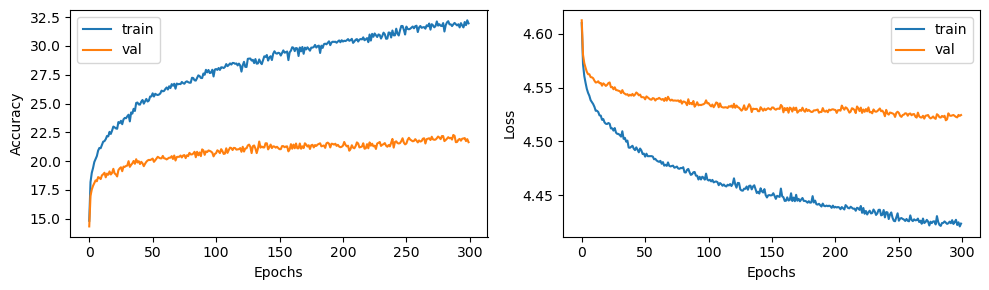

In [130]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

### Early stopping

In [131]:
# model + optimizer + criterion
model = CustomModel(input_size, hidden_size1, hidden_size2, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# ignite trainer + evaluators
trainer = create_supervised_trainer(model, optimizer, criterion, device)
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}
train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

# loggers + history appends
@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

In [132]:
# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]

In [136]:
# define early stopping and model checkpoint
handler = EarlyStopping(patience=50, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname='models25percent',
    filename_prefix='best_NOREG',
    n_saved=1,
    create_dir=True,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': model})

In [ ]:
trainer.run(train_loader, max_epochs=300)

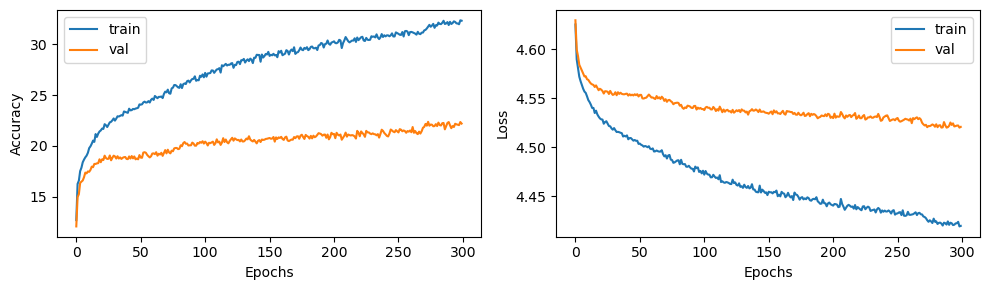

In [138]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

### L2 Regularization


#### https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)

In [139]:
class L2Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(L2Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [140]:
hidden_dim = 100

In [141]:
# model + optimizer + criterion
model = L2Model(input_size, hidden_dim, n_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

# ignite trainer + evaluators
trainer = create_supervised_trainer(model, optimizer, criterion, device)
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}
train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

# loggers + history appends
@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

In [142]:
# Define early stopping and model checkpoint
handler = EarlyStopping(patience=50, score_function=score_function, trainer=trainer)
checkpoint = ModelCheckpoint('models25percent', filename_prefix='best_L2', n_saved=1, global_step_transform=global_step_from_engine(trainer), require_empty=False)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': model})

In [143]:
trainer.run(train_loader, max_epochs=300)

Epoch[1], Iter[100] Loss: 4.48
Epoch[1], Iter[200] Loss: 3.77
Epoch[1], Iter[300] Loss: 3.71
Epoch[1], Iter[400] Loss: 3.96
Training Results - Epoch[1] Avg accuracy: 0.16 Avg loss: 3.43
Validation Results - Epoch[1] Avg accuracy: 0.15 Avg loss: 3.46
Epoch[2], Iter[500] Loss: 3.87
Epoch[2], Iter[600] Loss: 3.56
Epoch[2], Iter[700] Loss: 3.08
Epoch[2], Iter[800] Loss: 3.08
Epoch[2], Iter[900] Loss: 2.97
Training Results - Epoch[2] Avg accuracy: 0.21 Avg loss: 3.18
Validation Results - Epoch[2] Avg accuracy: 0.19 Avg loss: 3.26
Epoch[3], Iter[1000] Loss: 2.75
Epoch[3], Iter[1100] Loss: 3.53
Epoch[3], Iter[1200] Loss: 2.96
Epoch[3], Iter[1300] Loss: 2.99
Epoch[3], Iter[1400] Loss: 2.80
Training Results - Epoch[3] Avg accuracy: 0.23 Avg loss: 3.07
Validation Results - Epoch[3] Avg accuracy: 0.22 Avg loss: 3.17
Epoch[4], Iter[1500] Loss: 2.87
Epoch[4], Iter[1600] Loss: 3.25
Epoch[4], Iter[1700] Loss: 2.85
Epoch[4], Iter[1800] Loss: 3.37
Epoch[4], Iter[1900] Loss: 3.30
Training Results - Epoc

2024-06-16 13:04:40,651 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[121] Avg accuracy: 0.29 Avg loss: 3.12


State:
	iteration: 58322
	epoch: 121
	epoch_length: 482
	max_epochs: 300
	output: 0.6106751561164856
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

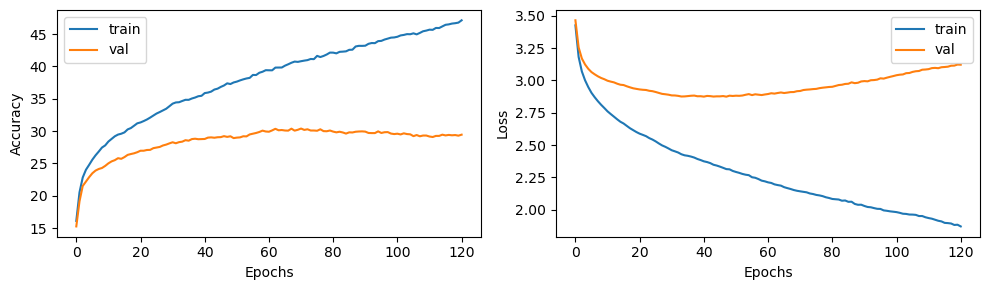

In [144]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

### Dropout

In [145]:
class DropoutModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.1):
        super(DropoutModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [146]:
# model + optimizer + criterion
model = DropoutModel(input_size, hidden_dim, n_classes, dropout_prob=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# ignite trainer + evaluators
trainer = create_supervised_trainer(model, optimizer, criterion, device)
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}
train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

# loggers + history appends
@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

In [147]:
# Define early stopping and model checkpoint
handler = EarlyStopping(patience=50, score_function=score_function, trainer=trainer)
checkpoint = ModelCheckpoint('models25percent', filename_prefix='best_DROP', n_saved=1, global_step_transform=global_step_from_engine(trainer), require_empty=False)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': model})

In [148]:
trainer.run(train_loader, max_epochs=300)

Epoch[1], Iter[100] Loss: 4.51
Epoch[1], Iter[200] Loss: 3.76
Epoch[1], Iter[300] Loss: 3.59
Epoch[1], Iter[400] Loss: 3.84
Training Results - Epoch[1] Avg accuracy: 0.17 Avg loss: 3.37
Validation Results - Epoch[1] Avg accuracy: 0.16 Avg loss: 3.41
Epoch[2], Iter[500] Loss: 3.77
Epoch[2], Iter[600] Loss: 3.44
Epoch[2], Iter[700] Loss: 3.23
Epoch[2], Iter[800] Loss: 2.85
Epoch[2], Iter[900] Loss: 3.03
Training Results - Epoch[2] Avg accuracy: 0.22 Avg loss: 3.12
Validation Results - Epoch[2] Avg accuracy: 0.20 Avg loss: 3.20
Epoch[3], Iter[1000] Loss: 2.74
Epoch[3], Iter[1100] Loss: 3.48
Epoch[3], Iter[1200] Loss: 2.97
Epoch[3], Iter[1300] Loss: 3.02
Epoch[3], Iter[1400] Loss: 2.67
Training Results - Epoch[3] Avg accuracy: 0.24 Avg loss: 3.00
Validation Results - Epoch[3] Avg accuracy: 0.22 Avg loss: 3.11
Epoch[4], Iter[1500] Loss: 2.90
Epoch[4], Iter[1600] Loss: 3.19
Epoch[4], Iter[1700] Loss: 2.74
Epoch[4], Iter[1800] Loss: 3.34
Epoch[4], Iter[1900] Loss: 3.27
Training Results - Epoc

2024-06-16 13:09:27,102 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[77] Avg accuracy: 0.29 Avg loss: 3.44


State:
	iteration: 37114
	epoch: 77
	epoch_length: 482
	max_epochs: 300
	output: 0.39449748396873474
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

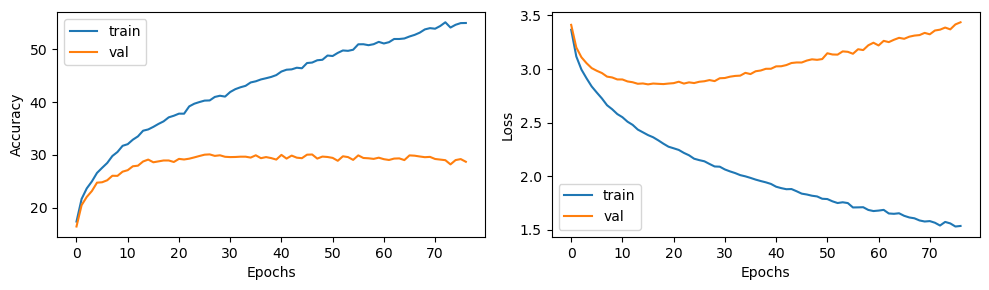

In [149]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

### Model Comparison

In [150]:
# saved models
import os
files = os.listdir('models25percent')

files

['best_DROP_model_77.pt', 'best_L2_model_121.pt', 'best_NOREG_model_300.pt']

In [251]:
criterion = nn.CrossEntropyLoss() # same criterion used while training
metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)} # same metrics used while training

In [152]:
def evaluate_model(evaluator, test_loader, criterion):
    state = evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    test_loss = metrics['loss']
    test_acc = metrics['accuracy']
    return test_loss, test_acc

In [153]:
# reinitialize models indentical to training to then load the state saved by pytorch ignite
best_NOREG_model = CustomModel(input_size, hidden_size1, hidden_size2, output_size)
best_NOREG_model.load_state_dict(torch.load('models/best_NOREG_model_149.pt'))

best_L2_model = L2Model(input_size, hidden_dim, n_classes)
best_L2_model.load_state_dict(torch.load('models/best_L2_model_99.pt'))

best_DROP_model = DropoutModel(input_size, hidden_dim, n_classes, dropout_prob=0.1)
best_DROP_model.load_state_dict(torch.load('models/best_DROP_model_89.pt'))

NOREG_evaluator = create_supervised_evaluator(best_NOREG_model, metrics=metrics, device=device) 
L2_evaluator = create_supervised_evaluator(best_L2_model, metrics=metrics, device=device) 
DROP_evaluator = create_supervised_evaluator(best_DROP_model, metrics=metrics, device=device) 

loss_ES, acc_ES = evaluate_model(NOREG_evaluator, test_loader, criterion)
loss_L2, acc_L2 = evaluate_model(L2_evaluator, test_loader, criterion)
loss_DROP, acc_DROP = evaluate_model(DROP_evaluator, test_loader, criterion)

print("Model without regularization - Loss: {:.4f}, Accuracy: {:.4f}".format(loss_ES, acc_ES))
print("Model with L2 regularization - Loss: {:.4f}, Accuracy: {:.4f}".format(loss_L2, acc_L2))
print("Model with Dropout - Loss: {:.4f}, Accuracy: {:.4f}".format(loss_DROP, acc_DROP))

Model without regularization - Loss: 4.5369, Accuracy: 0.2059
Model with L2 regularization - Loss: 4.0078, Accuracy: 0.2508
Model with Dropout - Loss: 4.6744, Accuracy: 0.2627


## Hyper-Parameter Tuning

In [178]:
class PyTorchModel(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes, activation):
        super(PyTorchModel, self).__init__()
        layers = []
        prev_size = input_dim
        
        # create linear layers with specified hidden layer sizes
        for size in hidden_layer_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(activation)
            prev_size = size
        
        # final output layer
        layers.append(nn.Linear(prev_size, n_classes))
        
        # sequentially stack all layers
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        # pass input through all layers and apply softmax activation
        return torch.softmax(self.layers(x), dim=-1)

In [179]:
class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden_layer_sizes, activation, optimizer_class, lr, epochs, device, metrics, criterion, batch_size, dropout_prob):
        self.input_dim = input_dim
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.optimizer_class = optimizer_class
        self.lr = lr
        self.epochs = epochs
        self.model = None
        self.optimizer = None
        self.device = device
        self.metrics = metrics
        self.criterion = criterion
        self.batch_size = batch_size
        self.dropout_prob = dropout_prob


    def fit(self, X, y):
        print("=======================================================")
        print("Fitting on Parameters:", 
              f"Input Dimension: {self.input_dim},\n"
              f"Hidden Layer Sizes: {self.hidden_layer_sizes},\n"
              f"Activation: {self.activation},\n"
              f"Optimizer Class: {self.optimizer_class},\n"
              f"Learning Rate: {self.lr},\n"
              f"Epochs: {self.epochs},\n"
              f"Device: {self.device},\n"
              f"Metrics: {self.metrics},\n"
              f"Criterion: {self.criterion},\n"
              f"Batch Size: {self.batch_size},\n"
        )

        # number of classes needed by BaseEstimator in classes_ variable
        self.classes_ = np.unique(y) 

        # initialize model + optimizer
        self.model = PyTorchModel(self.input_dim, self.hidden_layer_sizes, self.activation)
        self.optimizer = self.optimizer_class(self.model.parameters(), lr=self.lr)

        # create train loader with input tensor (from numpy)
        tensor_dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
        self.train_loader = DataLoader(tensor_dataset, batch_size=self.batch_size, shuffle=False)

        # initialize trainer and evaluator Pytorch Ignite
        self.trainer = create_supervised_trainer(self.model, self.optimizer, self.criterion, self.device)
        self.trainer.add_event_handler(Events.EPOCH_COMPLETED, self.log_training_results) # add logger handler to ignite trainer
        
        @self.trainer.on(Events.ITERATION_COMPLETED(every=10))
        def log_training_loss(engine):
            print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")
        
        # reset trainer state and run train
        self.trainer.state = State() # needed by RandomizedSearchCV multiple fit
        self.trainer.run(self.train_loader, max_epochs=self.epochs)

    def predict(self, X):
        # create a data loader with the input tensor
        data_loader = DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32)), batch_size=self.batch_size, shuffle=False)
        
        # set the model to evaluation mode
        self.model.eval()
        
        predictions = []
        with torch.no_grad(): # temporarily disable gradient calculation (no gradient needed during evaluation)
            for inputs in data_loader:
                # forward pass through the model
                outputs = self.model(inputs[0])
                # compute predictions
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.tolist())
        
        return np.array(predictions)

    def log_training_results(self, trainer): 
        # custom loop here rather than ignite evaluate (it triggers errors due to the function scope)
        self.model.eval() # set the model to evaluation mode
        total_loss = 0.0
        correct = 0
        total = 0
    
        with torch.no_grad(): # temporarily disable gradient calculation (no gradient needed during evaluation)
            for inputs, targets in self.train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
    
        accuracy = 100 * correct / total
        avg_loss = total_loss / len(self.train_loader)
    
        print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {accuracy:.2f} Avg loss: {avg_loss:.2f}")

In [180]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [181]:
param_grid = {
    'hidden_layer_sizes': [(128, 64, 32), (64, 32, 16), (256, 128, 64)],
    'activation': [nn.ReLU(), nn.Tanh()],
    'lr': [0.001, 0.01, 0.1, 1],
    'optimizer_class': [optim.Adam, optim.SGD],
    'epochs': [50, 100, 200],
    'batch_size': [32, 64, 128],
    'dropout_prob': [0.1, 0.2, 0.3, 0.4, 0.5]
}

In [182]:
clf = PyTorchClassifier(
    input_dim = input_size,
    hidden_layer_sizes = (128, 64, 32),
    activation = nn.ReLU(),
    dropout_prob = 0.1,
    optimizer_class = optim.Adam,
    lr = 0.001,
    epochs = 50,
    device = device,
    metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)},
    criterion = nn.CrossEntropyLoss(),
    batch_size = 32
)

In [ ]:
# perform randomized grid search
rs = RandomizedSearchCV(clf, param_grid, scoring='accuracy', verbose=True, n_iter=15, cv=3, error_score='raise')
rs.fit(X_train, y_train_encoded)

In [86]:
print(rs.best_score_, rs.best_params_)

0.1892860931501513 {'optimizer_class': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'hidden_layer_sizes': (256, 128, 64), 'epochs': 50, 'batch_size': 64, 'activation': Tanh()}


In [89]:
y_pred = rs.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test_encoded, y_pred))
print('F1-score %s' % f1_score(y_test_encoded, y_pred, average=None))
print(classification_report(y_test_encoded, y_pred))

# That didn't give the expected results, let's proceed with some trial and error and "manual" hyperparameter tuning

Accuracy 0.2018939393939394
F1-score [0.21176471 0.         0.         0.18181818 0.27272727 0.
 0.3125     0.09302326 0.         0.13333333 0.         0.
 0.         0.         0.272      0.         0.27027027 0.
 0.68085106 0.25       0.         0.         0.23529412 0.
 0.30612245 0.         0.         0.375      0.         0.
 0.         0.         0.         0.         0.         0.2173913
 0.         0.         0.         0.         0.         0.
 0.65753425 0.         0.140625   0.         0.         0.
 0.1509434  0.         0.12962963 0.25899281 0.22857143 0.38461538
 0.29333333 0.         0.         0.         0.         0.
 0.35443038 0.28828829 0.         0.         0.11111111 0.
 0.42857143 0.         0.         0.         0.13432836 0.
 0.23880597 0.         0.         0.38202247 0.35135135 0.27586207
 0.29059829 0.         0.         0.19512195 0.23333333 0.
 0.29508197 0.         0.         0.         0.         0.
 0.         0.         0.         0.44       0.2037037 

C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### "Manual" parameter tuning

In [59]:
df = pd.read_csv(r"C:\Users\rugge\Algorithms and Data Structures\final_clean_dataset.csv")

In [60]:
X = df[['duration_ms', 'popularity', 'danceability',
       'energy', 'speechiness', 'instrumentalness', 'liveness', 'valence',
       'time_signature', 'n_beats', 'fade_out_duration',
       'primary_artist_popularity', 'average_artists_popularity',
       'sum_of_followers', 'explicit']].values
y = np.array(df['genre'])

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18, stratify=y)


In [25]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [62]:
# creates validation set (we basically split the test set in two!)
X_val, X_new_test, y_val, y_new_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

In [27]:
# we have to encode our target variable!

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_new_test)  # Use the same encoder for test set
y_val_encoded = label_encoder.transform(y_val)  # Use the same encoder for validation set


In [50]:
# numpy to tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)

X_test_tensor = torch.tensor(X_new_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

In [51]:
# creates tensor dataset (can be later loaded)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [52]:
# creates data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

### Custom Model 1

In [247]:
class CustomModel1(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(CustomModel1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.softmax(x)  
        return x

In [260]:
#hyper-parameters

input_size = 15
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 32
output_size = 113
learning_rate = 0.001
epochs = 200
batch_size = 64
patience = 15
###
model = CustomModel1(input_size, hidden_size1, hidden_size2, hidden_size3, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}

In [264]:
# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
for name, metric in metrics.items():
    metric.attach(evaluator, name)

# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")
    
    val_loss = metrics['loss']
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch[1] Avg accuracy: 0.21 Avg loss: 4.71
Validation Results - Epoch[1] Avg accuracy: 0.21 Avg loss: 4.71
Training Results - Epoch[2] Avg accuracy: 0.23 Avg loss: 4.71
Validation Results - Epoch[2] Avg accuracy: 0.23 Avg loss: 4.71
Training Results - Epoch[3] Avg accuracy: 0.24 Avg loss: 4.70
Validation Results - Epoch[3] Avg accuracy: 0.24 Avg loss: 4.71
Training Results - Epoch[4] Avg accuracy: 0.25 Avg loss: 4.70
Validation Results - Epoch[4] Avg accuracy: 0.24 Avg loss: 4.70
Training Results - Epoch[5] Avg accuracy: 0.25 Avg loss: 4.70
Validation Results - Epoch[5] Avg accuracy: 0.25 Avg loss: 4.70
Training Results - Epoch[6] Avg accuracy: 0.26 Avg loss: 4.70
Validation Results - Epoch[6] Avg accuracy: 0.25 Avg loss: 4.70
Training Results - Epoch[7] Avg accuracy: 0.26 Avg loss: 4.70
Validation Results - Epoch[7] Avg accuracy: 0.26 Avg loss: 4.70
Training Results - Epoch[8] Avg accuracy: 0.27 Avg loss: 4.70
Validation Results - Epoch[8] Avg accuracy: 0.26 Avg los

State:
	iteration: 142450
	epoch: 74
	epoch_length: 1925
	max_epochs: 200
	output: 4.6941680908203125
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Custom Model 2 (+ Dropout regularization)

In [278]:
class CustomModel2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size, dropout_rate=0.2):
        # dropout_range in practice goes from 0.1 to 0.5
        super(CustomModel2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.tanh(self.fc3(x))
        x = self.dropout(x)
        x = self.tanh(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        x = self.softmax(x)
        return x

In [279]:
#hyper-parameters

input_size = 15
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 32
hidden_size4 = 16
output_size = 113
learning_rate = 0.01
epochs = 100 # Reducing epochs for testing purposes
batch_size = 32 # Smaller batch size to fit your data size
patience = 10
###
model = CustomModel2(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}

In [284]:
for name, metric in metrics.items():
    metric.attach(evaluator, name)

# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()


# Training loop
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch[13] Avg accuracy: 0.05 Avg loss: 4.70
Validation Results - Epoch[13] Avg accuracy: 0.05 Avg loss: 4.70
Training Results - Epoch[13] Avg accuracy: 0.05 Avg loss: 4.70
Validation Results - Epoch[13] Avg accuracy: 0.05 Avg loss: 4.70
Training Results - Epoch[13] Avg accuracy: 0.05 Avg loss: 4.70
Validation Results - Epoch[13] Avg accuracy: 0.05 Avg loss: 4.70
Training Results - Epoch[14] Avg accuracy: 0.05 Avg loss: 4.69
Validation Results - Epoch[14] Avg accuracy: 0.05 Avg loss: 4.69
Training Results - Epoch[14] Avg accuracy: 0.05 Avg loss: 4.69
Validation Results - Epoch[14] Avg accuracy: 0.05 Avg loss: 4.69
Training Results - Epoch[14] Avg accuracy: 0.05 Avg loss: 4.69
Validation Results - Epoch[14] Avg accuracy: 0.05 Avg loss: 4.69
Training Results - Epoch[15] Avg accuracy: 0.05 Avg loss: 4.70
Validation Results - Epoch[15] Avg accuracy: 0.05 Avg loss: 4.70
Training Results - Epoch[15] Avg accuracy: 0.05 Avg loss: 4.70
Validation Results - Epoch[15] Avg accura

State:
	iteration: 32725
	epoch: 17
	epoch_length: 1925
	max_epochs: 100
	output: 4.741448402404785
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

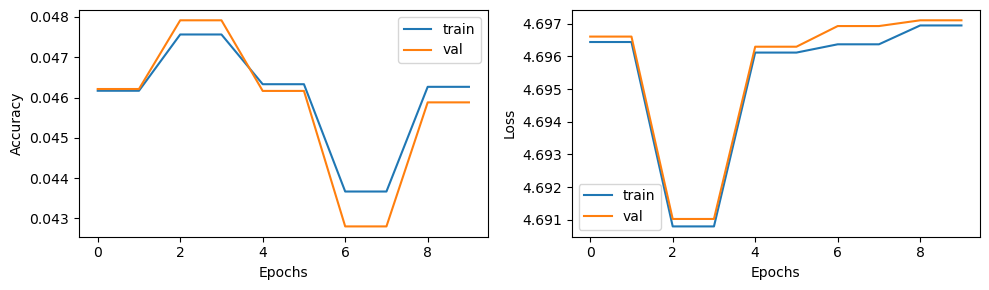

In [285]:
# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_accuracy, label='train')
axes[0].plot(validation_accuracy, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_loss, label='train')
axes[1].plot(validation_loss, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.tight_layout()
plt.show()

## Custom Model 3

In [286]:
### We are putting much of the blame of the previous bad performance to ReLU, and the learning rate of 0.01. 
### I would also like to add another hidden layer, if performance are still bad: then I'll go back to 3.

In [287]:
class CustomModel3(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, output_size, dropout_rate=0.1):
        # going down to 0.1 let's see what happens
        super(CustomModel3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.dropout(x)
        x = self.tanh(self.fc2(x))
        x = self.dropout(x)
        x = self.tanh(self.fc3(x))
        x = self.dropout(x)
        x = self.tanh(self.fc4(x))
        x = self.dropout(x)
        x = self.tanh(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.softmax(x)
        return x

In [288]:
#hyper-parameters

input_size = 15
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
hidden_size4 = 32
hidden_size5 = 16
output_size = 113
learning_rate = 0.001 # going back to 0.001
epochs = 100 
batch_size = 32 
patience = 10
###
model = CustomModel3(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) ## In the future I could think about using another optimizer!
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}

In [289]:
for name, metric in metrics.items():
    metric.attach(evaluator, name)

# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()


# Training loop
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch[18] Avg accuracy: 0.10 Avg loss: 4.65
Validation Results - Epoch[18] Avg accuracy: 0.10 Avg loss: 4.65
Training Results - Epoch[18] Avg accuracy: 0.10 Avg loss: 4.65
Validation Results - Epoch[18] Avg accuracy: 0.10 Avg loss: 4.65
Training Results - Epoch[18] Avg accuracy: 0.10 Avg loss: 4.65
Validation Results - Epoch[18] Avg accuracy: 0.10 Avg loss: 4.65
Training Results - Epoch[18] Avg accuracy: 0.10 Avg loss: 4.65
Validation Results - Epoch[18] Avg accuracy: 0.10 Avg loss: 4.65
Training Results - Epoch[19] Avg accuracy: 0.12 Avg loss: 4.62
Validation Results - Epoch[19] Avg accuracy: 0.12 Avg loss: 4.63
Training Results - Epoch[19] Avg accuracy: 0.12 Avg loss: 4.62
Validation Results - Epoch[19] Avg accuracy: 0.12 Avg loss: 4.63
Training Results - Epoch[19] Avg accuracy: 0.12 Avg loss: 4.62
Validation Results - Epoch[19] Avg accuracy: 0.12 Avg loss: 4.63
Training Results - Epoch[19] Avg accuracy: 0.12 Avg loss: 4.62
Validation Results - Epoch[19] Avg accura

State:
	iteration: 55825
	epoch: 29
	epoch_length: 1925
	max_epochs: 100
	output: 4.5235915184021
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

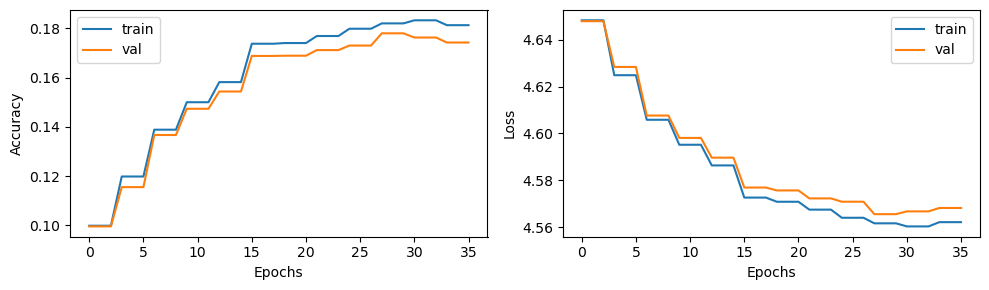

In [290]:
# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_accuracy, label='train')
axes[0].plot(validation_accuracy, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_loss, label='train')
axes[1].plot(validation_loss, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.tight_layout()
plt.show()

## Custom Model 4

In [ ]:
class CustomModel4(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.1):
        # let's keep dropout_rate at 0.1 becaues the model does not overfit (until now), but let's remove 2 layers, 
        # since task doesn't seem that complex
        super(CustomModel4, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.dropout(x)
        x = self.tanh(self.fc2(x))
        x = self.dropout(x)
        x = self.tanh(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

In [296]:
#hyper-parameters

input_size = 15
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16
output_size = 113
learning_rate = 0.001 # going back to 0.001
epochs = 100 
batch_size = 32 
patience = 10
###
model = CustomModel3(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) ## In the future I could think about using another optimizer!
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}

Training Results - Epoch[30] Avg accuracy: 0.08 Avg loss: 4.67
Validation Results - Epoch[30] Avg accuracy: 0.08 Avg loss: 4.67
Training Results - Epoch[30] Avg accuracy: 0.08 Avg loss: 4.67
Validation Results - Epoch[30] Avg accuracy: 0.08 Avg loss: 4.67
Training Results - Epoch[30] Avg accuracy: 0.08 Avg loss: 4.67
Validation Results - Epoch[30] Avg accuracy: 0.08 Avg loss: 4.67
Training Results - Epoch[30] Avg accuracy: 0.08 Avg loss: 4.67
Validation Results - Epoch[30] Avg accuracy: 0.08 Avg loss: 4.67
Training Results - Epoch[30] Avg accuracy: 0.08 Avg loss: 4.67
Validation Results - Epoch[30] Avg accuracy: 0.08 Avg loss: 4.67
Training Results - Epoch[31] Avg accuracy: 0.09 Avg loss: 4.65
Validation Results - Epoch[31] Avg accuracy: 0.09 Avg loss: 4.65
Training Results - Epoch[31] Avg accuracy: 0.09 Avg loss: 4.65
Validation Results - Epoch[31] Avg accuracy: 0.09 Avg loss: 4.65
Training Results - Epoch[31] Avg accuracy: 0.09 Avg loss: 4.65
Validation Results - Epoch[31] Avg accura

State:
	iteration: 117425
	epoch: 61
	epoch_length: 1925
	max_epochs: 100
	output: 4.577095031738281
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

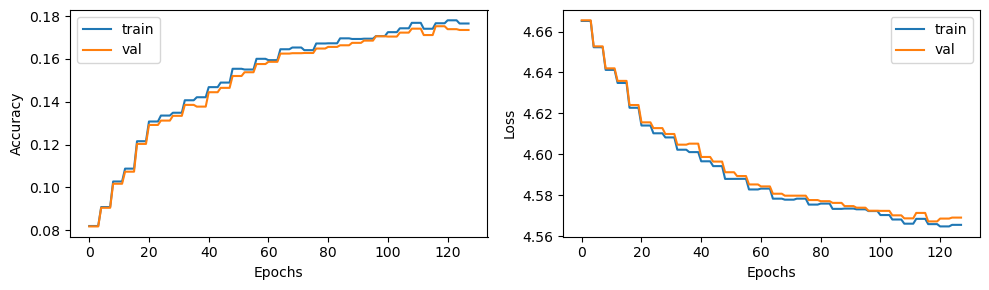

In [293]:
# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_accuracy, label='train')
axes[0].plot(validation_accuracy, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_loss, label='train')
axes[1].plot(validation_loss, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.tight_layout()
plt.show()

## Custom Model 5

In [297]:
# CustomModel5 without dropout (we will add L2 regularization instead)
class CustomModel5(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, weight_decay=0.01):
        # let's start from weight_decay = 0.01
        super(CustomModel5, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size) 
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
        # Optionally, you can add batch normalization or other layers here if needed

        # No dropout layer
        
        # No softmax here, since it will be included in CrossEntropyLoss if used with softmax

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

In [299]:
# Hyperparameters
input_size = 15
hidden_size1 = 256 # let's increase hidden sizes across all 3
hidden_size2 = 128
hidden_size3 = 64
output_size = 113
learning_rate = 0.001  # 0.001 has done a good job
epochs = 200
batch_size = 64
weight_decay = 0.01  # L2 regularization strength
patience = 15

# Create model instance
model = CustomModel5(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)

In [300]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch[1] Avg accuracy: 0.18 Avg loss: 3.52
Validation Results - Epoch[1] Avg accuracy: 0.17 Avg loss: 3.52
Training Results - Epoch[2] Avg accuracy: 0.18 Avg loss: 3.49
Validation Results - Epoch[2] Avg accuracy: 0.18 Avg loss: 3.49
Training Results - Epoch[3] Avg accuracy: 0.19 Avg loss: 3.47
Validation Results - Epoch[3] Avg accuracy: 0.18 Avg loss: 3.48
Training Results - Epoch[4] Avg accuracy: 0.19 Avg loss: 3.47
Validation Results - Epoch[4] Avg accuracy: 0.18 Avg loss: 3.48
Training Results - Epoch[5] Avg accuracy: 0.19 Avg loss: 3.46
Validation Results - Epoch[5] Avg accuracy: 0.18 Avg loss: 3.47
Training Results - Epoch[6] Avg accuracy: 0.19 Avg loss: 3.46
Validation Results - Epoch[6] Avg accuracy: 0.18 Avg loss: 3.47
Training Results - Epoch[7] Avg accuracy: 0.19 Avg loss: 3.46
Validation Results - Epoch[7] Avg accuracy: 0.19 Avg loss: 3.47
Training Results - Epoch[8] Avg accuracy: 0.19 Avg loss: 3.46
Validation Results - Epoch[8] Avg accuracy: 0.19 Avg los

State:
	iteration: 117425
	epoch: 61
	epoch_length: 1925
	max_epochs: 200
	output: 3.0467238426208496
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

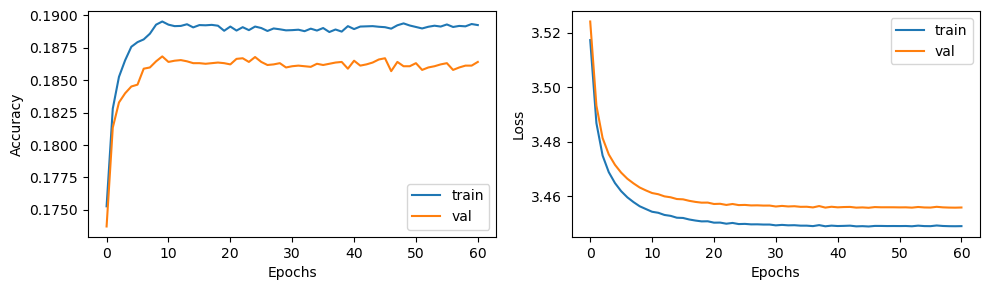

In [301]:
# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_accuracy, label='train')
axes[0].plot(validation_accuracy, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_loss, label='train')
axes[1].plot(validation_loss, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.tight_layout()
plt.show()

## Custom Model 6

In [302]:
### Loss function has never been so low, we should just get the accuracy up a bit... let's try some changes

In [313]:
# CustomModel5 without dropout (we will add L2 regularization instead)
class CustomModel6(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, weight_decay=0.01):
        # let's start from weight_decay = 0.01
        super(CustomModel6, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size) 
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
        # Optionally, you can add batch normalization or other layers here if needed

        # No dropout layer
        
        # No softmax here, since it will be included in CrossEntropyLoss if used with softmax

    def forward(self, x):
        x = self.relu(self.fc1(x)) #let's try RELU
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [314]:
# Hyperparameters
input_size = 15
hidden_size1 = 512 #let's increase them more! (maybe our model it's too simple!)
hidden_size2 = 256
hidden_size3 = 128
output_size = 113
learning_rate = 0.0001  # 0.0001 maybe we just need to decrease it?
epochs = 200
batch_size = 64
weight_decay = 0.01  # L2 regularization strength [=we could try 0.001 in the future but for now it's good]
patience = 15

# Create model instance
model = CustomModel6(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)

In [315]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch[1] Avg accuracy: 0.18 Avg loss: 3.46
Validation Results - Epoch[1] Avg accuracy: 0.17 Avg loss: 3.46
Training Results - Epoch[2] Avg accuracy: 0.20 Avg loss: 3.35
Validation Results - Epoch[2] Avg accuracy: 0.19 Avg loss: 3.36
Training Results - Epoch[3] Avg accuracy: 0.21 Avg loss: 3.29
Validation Results - Epoch[3] Avg accuracy: 0.20 Avg loss: 3.29
Training Results - Epoch[4] Avg accuracy: 0.21 Avg loss: 3.25
Validation Results - Epoch[4] Avg accuracy: 0.21 Avg loss: 3.26
Training Results - Epoch[5] Avg accuracy: 0.22 Avg loss: 3.23
Validation Results - Epoch[5] Avg accuracy: 0.21 Avg loss: 3.23
Training Results - Epoch[6] Avg accuracy: 0.22 Avg loss: 3.21
Validation Results - Epoch[6] Avg accuracy: 0.22 Avg loss: 3.22
Training Results - Epoch[7] Avg accuracy: 0.22 Avg loss: 3.20
Validation Results - Epoch[7] Avg accuracy: 0.22 Avg loss: 3.21
Training Results - Epoch[8] Avg accuracy: 0.22 Avg loss: 3.19
Validation Results - Epoch[8] Avg accuracy: 0.22 Avg los

State:
	iteration: 385000
	epoch: 200
	epoch_length: 1925
	max_epochs: 200
	output: 2.634600877761841
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

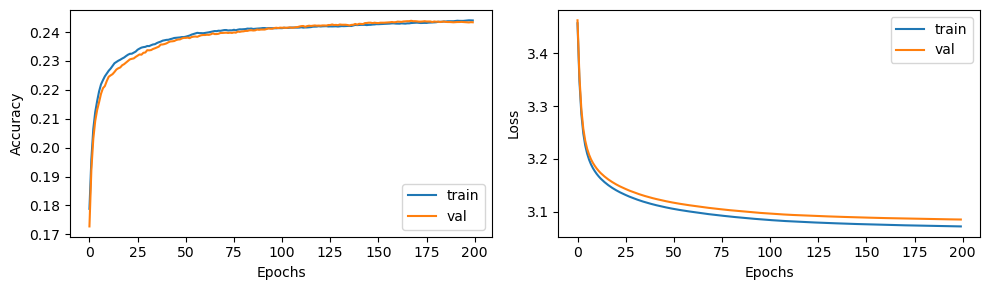

In [317]:
# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_accuracy, label='train')
axes[0].plot(validation_accuracy, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_loss, label='train')
axes[1].plot(validation_loss, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.tight_layout()
plt.show()

## Custom Model 7

In [316]:
### Model is not learning epoch after epoch... let's do some changes (like increase learning rate)

In [318]:
# CustomModel5 without dropout (we will add L2 regularization instead)
class CustomModel7(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, output_size, weight_decay=0.01):
        # In the future I could also decrease weight_decay to 0.001!
        super(CustomModel7, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, output_size) 
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
        # Optionally, you can add batch normalization or other layers here if needed

        # No dropout layer
        
        # No softmax here, since it will be included in CrossEntropyLoss if used with softmax

    def forward(self, x):
        x = self.relu(self.fc1(x)) #let's try RELU
        x = self.relu(self.fc2(x)) #Next time I could apply LeakyReLU or ELU
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [322]:
# Hyperparameters
input_size = 15
hidden_size1 = 512 #let's increase them more! (maybe our model it's too simple!)
hidden_size2 = 256
hidden_size3 = 128
hidden_size4 = 64
hidden_size5 = 32
output_size = 113
learning_rate = 0.001  # NEVER INCREASING IT TO 0.1 AGAIN! AWFUL!
epochs = 200
batch_size = 32 # back to 32... but keep an eye on it: smaller batch sizes can introduce more noise
weight_decay = 0.01  # L2 regularization strength [=we could try 0.001 in the future but for now it's good]
patience = 15

# Create model instance
model = CustomModel7(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)

In [323]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch[1] Avg accuracy: 0.01 Avg loss: 4.69
Validation Results - Epoch[1] Avg accuracy: 0.01 Avg loss: 4.69
Training Results - Epoch[2] Avg accuracy: 0.01 Avg loss: 4.69
Validation Results - Epoch[2] Avg accuracy: 0.01 Avg loss: 4.69
Training Results - Epoch[3] Avg accuracy: 0.01 Avg loss: 4.69
Validation Results - Epoch[3] Avg accuracy: 0.01 Avg loss: 4.69
Training Results - Epoch[4] Avg accuracy: 0.01 Avg loss: 4.69
Validation Results - Epoch[4] Avg accuracy: 0.01 Avg loss: 4.69
Training Results - Epoch[5] Avg accuracy: 0.01 Avg loss: 4.69
Validation Results - Epoch[5] Avg accuracy: 0.01 Avg loss: 4.69
Training Results - Epoch[6] Avg accuracy: 0.01 Avg loss: 4.69
Validation Results - Epoch[6] Avg accuracy: 0.01 Avg loss: 4.69
Training Results - Epoch[7] Avg accuracy: 0.01 Avg loss: 4.69
Validation Results - Epoch[7] Avg accuracy: 0.01 Avg loss: 4.69
Training Results - Epoch[8] Avg accuracy: 0.01 Avg loss: 4.69
Validation Results - Epoch[8] Avg accuracy: 0.01 Avg los

State:
	iteration: 146300
	epoch: 76
	epoch_length: 1925
	max_epochs: 200
	output: 4.682735443115234
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_accuracy, label='train')
axes[0].plot(validation_accuracy, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_loss, label='train')
axes[1].plot(validation_loss, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.tight_layout()
plt.show()

## Custom Model 8

In [324]:
## Maybe 3 number of hidden layers was perfect, let's change other parameters..

In [325]:
class CustomModel8(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, weight_decay=0.01):
        super(CustomModel8, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size) 
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
        # Optionally, you can add batch normalization or other layers here if needed

        # No dropout layer
        
        # No softmax here, since it will be included in CrossEntropyLoss if used with softmax

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))      
        x = self.fc4(x)
        return x

In [326]:
# Hyperparameters
input_size = 15
hidden_size1 = 512 
hidden_size2 = 256
hidden_size3 = 128
output_size = 113
learning_rate = 0.001 #decreased at 0.001 from 0.0001
epochs = 200
batch_size = 64
weight_decay = 0.01  # L2 regularization strength [=we could try 0.001 in the future but for now it's good]
patience = 15

# Create model instance
model = CustomModel8(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)

In [327]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch[1] Avg accuracy: 0.19 Avg loss: 3.37
Validation Results - Epoch[1] Avg accuracy: 0.19 Avg loss: 3.37
Training Results - Epoch[2] Avg accuracy: 0.20 Avg loss: 3.28
Validation Results - Epoch[2] Avg accuracy: 0.20 Avg loss: 3.29
Training Results - Epoch[3] Avg accuracy: 0.21 Avg loss: 3.25
Validation Results - Epoch[3] Avg accuracy: 0.21 Avg loss: 3.25
Training Results - Epoch[4] Avg accuracy: 0.21 Avg loss: 3.23
Validation Results - Epoch[4] Avg accuracy: 0.21 Avg loss: 3.24
Training Results - Epoch[5] Avg accuracy: 0.21 Avg loss: 3.22
Validation Results - Epoch[5] Avg accuracy: 0.21 Avg loss: 3.23
Training Results - Epoch[6] Avg accuracy: 0.21 Avg loss: 3.21
Validation Results - Epoch[6] Avg accuracy: 0.21 Avg loss: 3.22
Training Results - Epoch[7] Avg accuracy: 0.22 Avg loss: 3.21
Validation Results - Epoch[7] Avg accuracy: 0.22 Avg loss: 3.21
Training Results - Epoch[8] Avg accuracy: 0.22 Avg loss: 3.20
Validation Results - Epoch[8] Avg accuracy: 0.22 Avg los

State:
	iteration: 125125
	epoch: 65
	epoch_length: 1925
	max_epochs: 200
	output: 2.707122802734375
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Custom Model 9, probably the last one... everything it's useless...

In [329]:
# Let's introduce batch normalization, re-introduce dropout and keep leavy_relu since it was going alright

class CustomModel9(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(CustomModel9, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.dropout = nn.Dropout(0.5)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        
    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Hyperparameters
input_size = 15
hidden_size1 = 512 
hidden_size2 = 256
hidden_size3 = 128
output_size = 113
learning_rate = 0.001 
epochs = 200
batch_size = 64
weight_decay = 0.01
patience = 15

# Create model instance
model = CustomModel9(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [330]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch[1] Avg accuracy: 0.20 Avg loss: 3.53
Validation Results - Epoch[1] Avg accuracy: 0.19 Avg loss: 3.54
Training Results - Epoch[2] Avg accuracy: 0.20 Avg loss: 3.49
Validation Results - Epoch[2] Avg accuracy: 0.20 Avg loss: 3.49
Training Results - Epoch[3] Avg accuracy: 0.21 Avg loss: 3.48
Validation Results - Epoch[3] Avg accuracy: 0.21 Avg loss: 3.48
Training Results - Epoch[4] Avg accuracy: 0.21 Avg loss: 3.47
Validation Results - Epoch[4] Avg accuracy: 0.20 Avg loss: 3.48
Training Results - Epoch[5] Avg accuracy: 0.21 Avg loss: 3.48
Validation Results - Epoch[5] Avg accuracy: 0.20 Avg loss: 3.48
Training Results - Epoch[6] Avg accuracy: 0.21 Avg loss: 3.48
Validation Results - Epoch[6] Avg accuracy: 0.20 Avg loss: 3.48
Training Results - Epoch[7] Avg accuracy: 0.21 Avg loss: 3.46
Validation Results - Epoch[7] Avg accuracy: 0.21 Avg loss: 3.47
Training Results - Epoch[8] Avg accuracy: 0.21 Avg loss: 3.48
Validation Results - Epoch[8] Avg accuracy: 0.21 Avg los

State:
	iteration: 86625
	epoch: 45
	epoch_length: 1925
	max_epochs: 200
	output: 3.424541473388672
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## DropoutModelCustom

In [21]:
class DropoutModelCustom(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.1):
        super(DropoutModelCustom, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.tanh = nn.Tanh()

        
    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))      
        x = self.dropout(x)
        x = self.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

In [22]:
# Hyperparameters
hidden_size = 128
learning_rate = 0.001 
epochs = 200
batch_size = 64
weight_decay = 0.01
patience = 15

# Create model instance
model = DropoutModelCustom(input_size, hidden_size, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [23]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch[1] Avg accuracy: 0.08 Avg loss: 3.91
Validation Results - Epoch[1] Avg accuracy: 0.07 Avg loss: 3.92
Training Results - Epoch[2] Avg accuracy: 0.09 Avg loss: 3.86
Validation Results - Epoch[2] Avg accuracy: 0.09 Avg loss: 3.87
Training Results - Epoch[3] Avg accuracy: 0.10 Avg loss: 3.82
Validation Results - Epoch[3] Avg accuracy: 0.10 Avg loss: 3.83
Training Results - Epoch[4] Avg accuracy: 0.11 Avg loss: 3.79
Validation Results - Epoch[4] Avg accuracy: 0.11 Avg loss: 3.79
Training Results - Epoch[5] Avg accuracy: 0.11 Avg loss: 3.76
Validation Results - Epoch[5] Avg accuracy: 0.11 Avg loss: 3.76
Training Results - Epoch[6] Avg accuracy: 0.13 Avg loss: 3.70
Validation Results - Epoch[6] Avg accuracy: 0.13 Avg loss: 3.70
Training Results - Epoch[7] Avg accuracy: 0.14 Avg loss: 3.64
Validation Results - Epoch[7] Avg accuracy: 0.14 Avg loss: 3.64
Training Results - Epoch[8] Avg accuracy: 0.14 Avg loss: 3.62
Validation Results - Epoch[8] Avg accuracy: 0.14 Avg los

State:
	iteration: 217525
	epoch: 113
	epoch_length: 1925
	max_epochs: 200
	output: 3.147204875946045
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## DropoutModelCustom2

In [27]:
class DropoutModelCustom2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.1):
        super(DropoutModelCustom2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [29]:
# Hyperparameters
hidden_size = 64
learning_rate = 0.001 
epochs = 200
batch_size = 32
patience = 15

# Create model instance
model = DropoutModelCustom2(input_size, hidden_size, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=weight_decay without L2 regularization)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [30]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch[1] Avg accuracy: 0.24 Avg loss: 3.06
Validation Results - Epoch[1] Avg accuracy: 0.24 Avg loss: 3.07
Training Results - Epoch[2] Avg accuracy: 0.27 Avg loss: 2.92
Validation Results - Epoch[2] Avg accuracy: 0.27 Avg loss: 2.94
Training Results - Epoch[3] Avg accuracy: 0.28 Avg loss: 2.84
Validation Results - Epoch[3] Avg accuracy: 0.28 Avg loss: 2.87
Training Results - Epoch[4] Avg accuracy: 0.29 Avg loss: 2.77
Validation Results - Epoch[4] Avg accuracy: 0.29 Avg loss: 2.81
Training Results - Epoch[5] Avg accuracy: 0.30 Avg loss: 2.73
Validation Results - Epoch[5] Avg accuracy: 0.30 Avg loss: 2.77
Training Results - Epoch[6] Avg accuracy: 0.31 Avg loss: 2.69
Validation Results - Epoch[6] Avg accuracy: 0.30 Avg loss: 2.74
Training Results - Epoch[7] Avg accuracy: 0.31 Avg loss: 2.66
Validation Results - Epoch[7] Avg accuracy: 0.31 Avg loss: 2.71
Training Results - Epoch[8] Avg accuracy: 0.32 Avg loss: 2.63
Validation Results - Epoch[8] Avg accuracy: 0.31 Avg los

State:
	iteration: 385000
	epoch: 200
	epoch_length: 1925
	max_epochs: 200
	output: 2.295240879058838
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

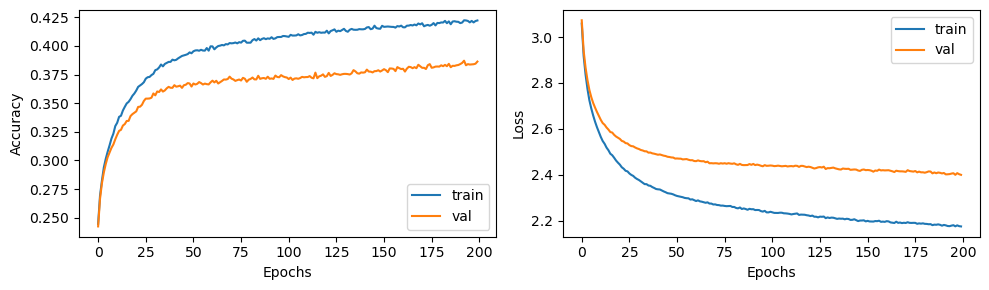

In [31]:
# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_accuracy, label='train')
axes[0].plot(validation_accuracy, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_loss, label='train')
axes[1].plot(validation_loss, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.tight_layout()
plt.show()

## Custom Model 10

In [32]:
## We are going in the right direction with the previous model! The model shows almost no sign of overfitting, so we are going to build on 
## that and try to improve the model further, helping it to detect more complex patterns (hopefully!).

In [35]:
class CustomModel10(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.1):
        super(CustomModel10, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [40]:
# Hyperparameters
hidden_size = 128
learning_rate = 0.0005 
epochs = 200
batch_size = 16
patience = 15

# Create model instance
model = CustomModel10(input_size, hidden_size, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()


In [41]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define training and evaluation steps
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def val_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

trainer = Engine(train_step)
evaluator = Engine(val_step)

# Attach metrics
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Early stopping handler
handler = EarlyStopping(patience=patience, score_function=lambda engine: -engine.state.metrics['loss'], trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, handler)

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers for logging results
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

# Learning rate scheduler step
@trainer.on(Events.EPOCH_COMPLETED)
def adjust_learning_rate(engine):
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']
    scheduler.step(val_loss)
    print(f'Epoch {engine.state.epoch}, Validation Loss: {val_loss:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

# Start training
trainer.run(train_loader, max_epochs=epochs)

# Print final metrics
print("Training finished. Best Validation Loss:", best_val_loss)

Training Results - Epoch[1] Avg accuracy: 0.20 Avg loss: 3.37
Validation Results - Epoch[1] Avg accuracy: 0.20 Avg loss: 3.37
Epoch 1, Validation Loss: 3.3715, Learning Rate: 0.000500
Training Results - Epoch[2] Avg accuracy: 0.21 Avg loss: 3.30
Validation Results - Epoch[2] Avg accuracy: 0.21 Avg loss: 3.30
Epoch 2, Validation Loss: 3.3020, Learning Rate: 0.000500
Training Results - Epoch[3] Avg accuracy: 0.22 Avg loss: 3.26
Validation Results - Epoch[3] Avg accuracy: 0.22 Avg loss: 3.27
Epoch 3, Validation Loss: 3.2694, Learning Rate: 0.000500
Training Results - Epoch[4] Avg accuracy: 0.22 Avg loss: 3.24
Validation Results - Epoch[4] Avg accuracy: 0.22 Avg loss: 3.25
Epoch 4, Validation Loss: 3.2520, Learning Rate: 0.000500
Training Results - Epoch[5] Avg accuracy: 0.22 Avg loss: 3.23
Validation Results - Epoch[5] Avg accuracy: 0.22 Avg loss: 3.24
Epoch 5, Validation Loss: 3.2407, Learning Rate: 0.000500
Training Results - Epoch[6] Avg accuracy: 0.22 Avg loss: 3.22
Validation Results

2024-06-17 10:03:51,670 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[66] Avg accuracy: 0.23 Avg loss: 3.19


2024-06-17 10:03:52,156 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[66] Avg accuracy: 0.23 Avg loss: 3.20


2024-06-17 10:03:52,658 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 66, Validation Loss: 3.1993, Learning Rate: 0.000500
Training finished. Best Validation Loss: 2.4001605409564393


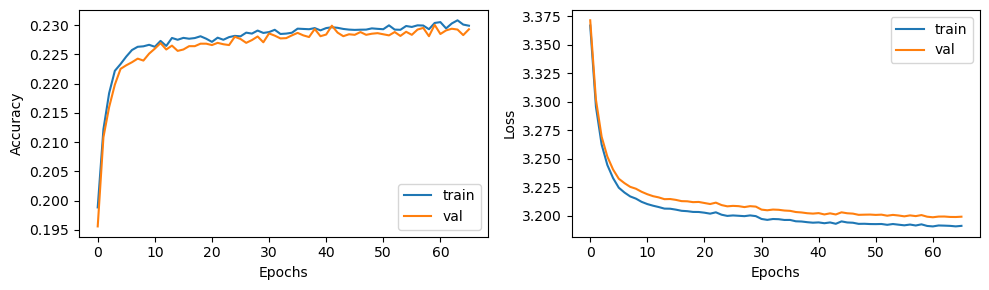

In [42]:
# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_accuracy, label='train')
axes[0].plot(validation_accuracy, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_loss, label='train')
axes[1].plot(validation_loss, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.tight_layout()
plt.show()

## Custom Model 11

In [43]:
class CustomModel11(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.1):
        super(CustomModel11, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [44]:
# Hyperparameters
hidden_size = 128 ## I could revert it back to 64
learning_rate = 0.001
epochs = 200
batch_size = 16 ## I could revert it back to 32
patience = 15

# Create model instance
model = CustomModel11(input_size, hidden_size, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()


In [45]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define training and evaluation steps
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def val_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

trainer = Engine(train_step)
evaluator = Engine(val_step)

# Attach metrics
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Early stopping handler
handler = EarlyStopping(patience=patience, score_function=lambda engine: -engine.state.metrics['loss'], trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, handler)

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers for logging results
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

# Learning rate scheduler step
@trainer.on(Events.EPOCH_COMPLETED)
def adjust_learning_rate(engine):
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']
    scheduler.step(val_loss)
    print(f'Epoch {engine.state.epoch}, Validation Loss: {val_loss:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

# Start training
trainer.run(train_loader, max_epochs=epochs)

# Print final metrics
print("Training finished. Best Validation Loss:", best_val_loss)

Training Results - Epoch[1] Avg accuracy: 0.20 Avg loss: 3.33
Validation Results - Epoch[1] Avg accuracy: 0.20 Avg loss: 3.34
Epoch 1, Validation Loss: 3.3399, Learning Rate: 0.001000
Training Results - Epoch[2] Avg accuracy: 0.21 Avg loss: 3.28
Validation Results - Epoch[2] Avg accuracy: 0.21 Avg loss: 3.29
Epoch 2, Validation Loss: 3.2886, Learning Rate: 0.001000
Training Results - Epoch[3] Avg accuracy: 0.22 Avg loss: 3.26
Validation Results - Epoch[3] Avg accuracy: 0.21 Avg loss: 3.27
Epoch 3, Validation Loss: 3.2688, Learning Rate: 0.001000
Training Results - Epoch[4] Avg accuracy: 0.22 Avg loss: 3.25
Validation Results - Epoch[4] Avg accuracy: 0.21 Avg loss: 3.26
Epoch 4, Validation Loss: 3.2612, Learning Rate: 0.001000
Training Results - Epoch[5] Avg accuracy: 0.22 Avg loss: 3.25
Validation Results - Epoch[5] Avg accuracy: 0.22 Avg loss: 3.26
Epoch 5, Validation Loss: 3.2557, Learning Rate: 0.001000
Training Results - Epoch[6] Avg accuracy: 0.22 Avg loss: 3.25
Validation Results

2024-06-17 10:07:27,251 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[38] Avg accuracy: 0.22 Avg loss: 3.22


2024-06-17 10:07:27,752 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[38] Avg accuracy: 0.22 Avg loss: 3.23


2024-06-17 10:07:28,229 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 38, Validation Loss: 3.2314, Learning Rate: 0.001000
Training finished. Best Validation Loss: 2.4001605409564393


## Custom Model 12

In [46]:
class CustomModel12(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.1):
        super(CustomModel12, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [47]:
# Hyperparameters
hidden_size = 64 ## I could revert it back to 64
learning_rate = 0.001
epochs = 200
batch_size = 16 ## I could revert it back to 32
patience = 15

# Create model instance
model = CustomModel12(input_size, hidden_size, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()


In [48]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define training and evaluation steps
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def val_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

trainer = Engine(train_step)
evaluator = Engine(val_step)

# Attach metrics
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Early stopping handler
handler = EarlyStopping(patience=patience, score_function=lambda engine: -engine.state.metrics['loss'], trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, handler)

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers for logging results
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

# Learning rate scheduler step
@trainer.on(Events.EPOCH_COMPLETED)
def adjust_learning_rate(engine):
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']
    scheduler.step(val_loss)
    print(f'Epoch {engine.state.epoch}, Validation Loss: {val_loss:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

# Start training
trainer.run(train_loader, max_epochs=epochs)

# Print final metrics
print("Training finished. Best Validation Loss:", best_val_loss)

Training Results - Epoch[1] Avg accuracy: 0.19 Avg loss: 3.40
Validation Results - Epoch[1] Avg accuracy: 0.19 Avg loss: 3.41
Epoch 1, Validation Loss: 3.4075, Learning Rate: 0.001000
Training Results - Epoch[2] Avg accuracy: 0.21 Avg loss: 3.33
Validation Results - Epoch[2] Avg accuracy: 0.20 Avg loss: 3.33
Epoch 2, Validation Loss: 3.3309, Learning Rate: 0.001000
Training Results - Epoch[3] Avg accuracy: 0.21 Avg loss: 3.29
Validation Results - Epoch[3] Avg accuracy: 0.21 Avg loss: 3.30
Epoch 3, Validation Loss: 3.2952, Learning Rate: 0.001000
Training Results - Epoch[4] Avg accuracy: 0.22 Avg loss: 3.27
Validation Results - Epoch[4] Avg accuracy: 0.21 Avg loss: 3.27
Epoch 4, Validation Loss: 3.2743, Learning Rate: 0.001000
Training Results - Epoch[5] Avg accuracy: 0.22 Avg loss: 3.26
Validation Results - Epoch[5] Avg accuracy: 0.22 Avg loss: 3.26
Epoch 5, Validation Loss: 3.2638, Learning Rate: 0.001000
Training Results - Epoch[6] Avg accuracy: 0.22 Avg loss: 3.25
Validation Results

2024-06-17 10:10:59,122 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[37] Avg accuracy: 0.22 Avg loss: 3.23


2024-06-17 10:10:59,649 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[37] Avg accuracy: 0.22 Avg loss: 3.24


2024-06-17 10:11:00,230 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 37, Validation Loss: 3.2373, Learning Rate: 0.001000
Training finished. Best Validation Loss: 2.4001605409564393


## Custom Model 13

In [49]:
class CustomModel13(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.1):
        super(CustomModel13, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [50]:
# Hyperparameters
hidden_size = 128 ## I could revert it back to 64
learning_rate = 0.001
epochs = 200
batch_size = 32 ## I could revert it back to 32
patience = 15

# Create model instance
model = CustomModel13(input_size, hidden_size, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()


In [51]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define training and evaluation steps
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def val_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

trainer = Engine(train_step)
evaluator = Engine(val_step)

# Attach metrics
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Early stopping handler
handler = EarlyStopping(patience=patience, score_function=lambda engine: -engine.state.metrics['loss'], trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, handler)

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers for logging results
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

# Learning rate scheduler step
@trainer.on(Events.EPOCH_COMPLETED)
def adjust_learning_rate(engine):
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']
    scheduler.step(val_loss)
    print(f'Epoch {engine.state.epoch}, Validation Loss: {val_loss:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

# Start training
trainer.run(train_loader, max_epochs=epochs)

# Print final metrics
print("Training finished. Best Validation Loss:", best_val_loss)

Training Results - Epoch[1] Avg accuracy: 0.20 Avg loss: 3.33
Validation Results - Epoch[1] Avg accuracy: 0.20 Avg loss: 3.33
Epoch 1, Validation Loss: 3.3319, Learning Rate: 0.001000
Training Results - Epoch[2] Avg accuracy: 0.21 Avg loss: 3.28
Validation Results - Epoch[2] Avg accuracy: 0.21 Avg loss: 3.28
Epoch 2, Validation Loss: 3.2825, Learning Rate: 0.001000
Training Results - Epoch[3] Avg accuracy: 0.22 Avg loss: 3.26
Validation Results - Epoch[3] Avg accuracy: 0.21 Avg loss: 3.27
Epoch 3, Validation Loss: 3.2677, Learning Rate: 0.001000
Training Results - Epoch[4] Avg accuracy: 0.22 Avg loss: 3.25
Validation Results - Epoch[4] Avg accuracy: 0.22 Avg loss: 3.26
Epoch 4, Validation Loss: 3.2586, Learning Rate: 0.001000
Training Results - Epoch[5] Avg accuracy: 0.22 Avg loss: 3.25
Validation Results - Epoch[5] Avg accuracy: 0.22 Avg loss: 3.25
Epoch 5, Validation Loss: 3.2535, Learning Rate: 0.001000
Training Results - Epoch[6] Avg accuracy: 0.22 Avg loss: 3.24
Validation Results

2024-06-17 10:14:53,767 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[40] Avg accuracy: 0.22 Avg loss: 3.22


2024-06-17 10:14:54,286 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[40] Avg accuracy: 0.22 Avg loss: 3.23


2024-06-17 10:14:54,819 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 40, Validation Loss: 3.2317, Learning Rate: 0.001000
Training finished. Best Validation Loss: 2.4001605409564393


## Custom Model 14

In [56]:
class CustomModel14(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.1):
        super(CustomModel14, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [57]:
# Hyperparameters
hidden_size = 64 ## Is 64 optimal?
learning_rate = 0.001 ## Let's see if adaptive 0.001 performs a bit better than non-adaptive 0.001, ceteris paribus
epochs = 200
batch_size = 32 ## Is 32 optimal?
patience = 15

# Create model instance
model = CustomModel14(input_size, hidden_size, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()


In [58]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define training and evaluation steps
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def val_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

trainer = Engine(train_step)
evaluator = Engine(val_step)

# Attach metrics
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Early stopping handler
handler = EarlyStopping(patience=patience, score_function=lambda engine: -engine.state.metrics['loss'], trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, handler)

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers for logging results
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

# Learning rate scheduler step
@trainer.on(Events.EPOCH_COMPLETED)
def adjust_learning_rate(engine):
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']
    scheduler.step(val_loss)
    print(f'Epoch {engine.state.epoch}, Validation Loss: {val_loss:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

# Start training
trainer.run(train_loader, max_epochs=epochs)

# Print final metrics
print("Training finished. Best Validation Loss:", best_val_loss)

Training Results - Epoch[1] Avg accuracy: 0.20 Avg loss: 3.38
Validation Results - Epoch[1] Avg accuracy: 0.19 Avg loss: 3.38
Epoch 1, Validation Loss: 3.3816, Learning Rate: 0.001000
Training Results - Epoch[2] Avg accuracy: 0.21 Avg loss: 3.30
Validation Results - Epoch[2] Avg accuracy: 0.21 Avg loss: 3.31
Epoch 2, Validation Loss: 3.3078, Learning Rate: 0.001000
Training Results - Epoch[3] Avg accuracy: 0.22 Avg loss: 3.28
Validation Results - Epoch[3] Avg accuracy: 0.21 Avg loss: 3.28
Epoch 3, Validation Loss: 3.2811, Learning Rate: 0.001000
Training Results - Epoch[4] Avg accuracy: 0.22 Avg loss: 3.26
Validation Results - Epoch[4] Avg accuracy: 0.22 Avg loss: 3.27
Epoch 4, Validation Loss: 3.2673, Learning Rate: 0.001000
Training Results - Epoch[5] Avg accuracy: 0.22 Avg loss: 3.25
Validation Results - Epoch[5] Avg accuracy: 0.22 Avg loss: 3.26
Epoch 5, Validation Loss: 3.2605, Learning Rate: 0.001000
Training Results - Epoch[6] Avg accuracy: 0.22 Avg loss: 3.25
Validation Results

2024-06-17 10:18:56,385 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[36] Avg accuracy: 0.22 Avg loss: 3.23


2024-06-17 10:18:56,887 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[36] Avg accuracy: 0.22 Avg loss: 3.23


2024-06-17 10:18:57,414 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 36, Validation Loss: 3.2324, Learning Rate: 0.001000
Training finished. Best Validation Loss: 2.4001605409564393


In [59]:
## Adaptive learning rate sucks! Let's stick to non-adaptive learning rate and let's lower it down to 0.0005!

## Custom Model 15

In [60]:
class CustomModel15(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.1):
        super(CustomModel15, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [62]:
# Hyperparameters
hidden_size = 64
learning_rate = 0.0005
epochs = 200
batch_size = 32
patience = 15

# Create model instance
model = CustomModel15(input_size, hidden_size, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=weight_decay without L2 regularization)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [63]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch[1] Avg accuracy: 0.22 Avg loss: 3.18
Validation Results - Epoch[1] Avg accuracy: 0.22 Avg loss: 3.19
Training Results - Epoch[2] Avg accuracy: 0.25 Avg loss: 3.04
Validation Results - Epoch[2] Avg accuracy: 0.24 Avg loss: 3.06
Training Results - Epoch[3] Avg accuracy: 0.26 Avg loss: 2.96
Validation Results - Epoch[3] Avg accuracy: 0.26 Avg loss: 2.99
Training Results - Epoch[4] Avg accuracy: 0.27 Avg loss: 2.91
Validation Results - Epoch[4] Avg accuracy: 0.27 Avg loss: 2.93
Training Results - Epoch[5] Avg accuracy: 0.28 Avg loss: 2.86
Validation Results - Epoch[5] Avg accuracy: 0.28 Avg loss: 2.89
Training Results - Epoch[6] Avg accuracy: 0.28 Avg loss: 2.83
Validation Results - Epoch[6] Avg accuracy: 0.28 Avg loss: 2.86
Training Results - Epoch[7] Avg accuracy: 0.29 Avg loss: 2.80
Validation Results - Epoch[7] Avg accuracy: 0.29 Avg loss: 2.83
Training Results - Epoch[8] Avg accuracy: 0.30 Avg loss: 2.76
Validation Results - Epoch[8] Avg accuracy: 0.29 Avg los

State:
	iteration: 385000
	epoch: 200
	epoch_length: 1925
	max_epochs: 200
	output: 2.2286124229431152
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [65]:
## Ok, learning rate = 0.001 is slightly preferred.
## Let's try hidden_size = 128 to make the model detect more complex patterns!

## Custom Model 16

In [69]:
class CustomModel16(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.1):
        super(CustomModel16, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [70]:
# Hyperparameters
hidden_size = 128 ## we increased it to detect more complex patterns hopefully
learning_rate = 0.001
epochs = 200
batch_size = 32
patience = 10

# Create model instance
model = CustomModel16(input_size, hidden_size, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=weight_decay without L2 regularization)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [71]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch[1] Avg accuracy: 0.26 Avg loss: 2.94
Validation Results - Epoch[1] Avg accuracy: 0.26 Avg loss: 2.97
Training Results - Epoch[2] Avg accuracy: 0.29 Avg loss: 2.78
Validation Results - Epoch[2] Avg accuracy: 0.28 Avg loss: 2.83
Training Results - Epoch[3] Avg accuracy: 0.31 Avg loss: 2.68
Validation Results - Epoch[3] Avg accuracy: 0.30 Avg loss: 2.74
Training Results - Epoch[4] Avg accuracy: 0.32 Avg loss: 2.60
Validation Results - Epoch[4] Avg accuracy: 0.31 Avg loss: 2.68
Training Results - Epoch[5] Avg accuracy: 0.34 Avg loss: 2.55
Validation Results - Epoch[5] Avg accuracy: 0.32 Avg loss: 2.64
Training Results - Epoch[6] Avg accuracy: 0.35 Avg loss: 2.50
Validation Results - Epoch[6] Avg accuracy: 0.33 Avg loss: 2.61
Training Results - Epoch[7] Avg accuracy: 0.35 Avg loss: 2.46
Validation Results - Epoch[7] Avg accuracy: 0.34 Avg loss: 2.58
Training Results - Epoch[8] Avg accuracy: 0.36 Avg loss: 2.43
Validation Results - Epoch[8] Avg accuracy: 0.34 Avg los

State:
	iteration: 88550
	epoch: 46
	epoch_length: 1925
	max_epochs: 200
	output: 2.0958681106567383
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Custom Model 17

In [ ]:
### Since our model does not show big signs of overfitting, we are removing dropout!

In [72]:
class CustomModel17(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CustomModel17, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [73]:
# Hyperparameters
hidden_size = 128 ## it is probably optimal hidden_size! we keep it like this! (we could probably think about increasing to 256)
learning_rate = 0.001
epochs = 200
batch_size = 32 
## we could think about batch_size = 16 now that we removed dropout, because the "added noise" could have a regularization effect
patience = 10

# Create model instance
model = CustomModel17(input_size, hidden_size, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=weight_decay without L2 regularization)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [76]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch[9] Avg accuracy: 0.36 Avg loss: 2.43
Validation Results - Epoch[9] Avg accuracy: 0.34 Avg loss: 2.58
Training Results - Epoch[9] Avg accuracy: 0.36 Avg loss: 2.43
Validation Results - Epoch[9] Avg accuracy: 0.34 Avg loss: 2.58
Training Results - Epoch[9] Avg accuracy: 0.36 Avg loss: 2.43
Validation Results - Epoch[9] Avg accuracy: 0.34 Avg loss: 2.58
Training Results - Epoch[10] Avg accuracy: 0.37 Avg loss: 2.39
Validation Results - Epoch[10] Avg accuracy: 0.34 Avg loss: 2.56
Training Results - Epoch[10] Avg accuracy: 0.37 Avg loss: 2.39
Validation Results - Epoch[10] Avg accuracy: 0.34 Avg loss: 2.56
Training Results - Epoch[10] Avg accuracy: 0.37 Avg loss: 2.39
Validation Results - Epoch[10] Avg accuracy: 0.34 Avg loss: 2.56
Training Results - Epoch[11] Avg accuracy: 0.37 Avg loss: 2.36
Validation Results - Epoch[11] Avg accuracy: 0.34 Avg loss: 2.54
Training Results - Epoch[11] Avg accuracy: 0.37 Avg loss: 2.36
Validation Results - Epoch[11] Avg accuracy: 0.

State:
	iteration: 46200
	epoch: 25
	epoch_length: 1925
	max_epochs: 200
	output: 2.066490650177002
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Custom Model 18

In [77]:
## Model with Dropout normalization performed slightly better, no need to batch_size = 16 for now
## First of all, let's try to increase hidden_size to 256, to see if the model can recognize even harder patterns

In [79]:
class CustomModel18(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.1):
        super(CustomModel18, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [80]:
# Hyperparameters
hidden_size = 256 ## let's see if it can detect more complex patterns!
learning_rate = 0.001
epochs = 200
batch_size = 32 
patience = 10

# Create model instance
model = CustomModel18(input_size, hidden_size, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=weight_decay without L2 regularization)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [81]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)


Training Results - Epoch[1] Avg accuracy: 0.28 Avg loss: 2.83
Validation Results - Epoch[1] Avg accuracy: 0.27 Avg loss: 2.88
Training Results - Epoch[2] Avg accuracy: 0.31 Avg loss: 2.65
Validation Results - Epoch[2] Avg accuracy: 0.30 Avg loss: 2.73
Training Results - Epoch[3] Avg accuracy: 0.34 Avg loss: 2.54
Validation Results - Epoch[3] Avg accuracy: 0.32 Avg loss: 2.65
Training Results - Epoch[4] Avg accuracy: 0.35 Avg loss: 2.45
Validation Results - Epoch[4] Avg accuracy: 0.33 Avg loss: 2.59
Training Results - Epoch[5] Avg accuracy: 0.37 Avg loss: 2.38
Validation Results - Epoch[5] Avg accuracy: 0.34 Avg loss: 2.54
Training Results - Epoch[6] Avg accuracy: 0.39 Avg loss: 2.31
Validation Results - Epoch[6] Avg accuracy: 0.35 Avg loss: 2.50
Training Results - Epoch[7] Avg accuracy: 0.40 Avg loss: 2.26
Validation Results - Epoch[7] Avg accuracy: 0.36 Avg loss: 2.48
Training Results - Epoch[8] Avg accuracy: 0.41 Avg loss: 2.22
Validation Results - Epoch[8] Avg accuracy: 0.37 Avg los

State:
	iteration: 48125
	epoch: 25
	epoch_length: 1925
	max_epochs: 200
	output: 2.034717321395874
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [82]:
## Finally some overfitting! Let's increase dropout_prob by 0.1 and let's try and add another hidden layer!

## Custom Model 19

In [84]:
class CustomModel19(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, output_dim, dropout_prob=0.2):
        # let's slightly increase dropout_prob!
        super(CustomModel19, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim1)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim1, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [85]:
# Hyperparameters
hidden_size = 256 ## complex patterns at the start
hidden_size1 = 128 ## slightly less complex towards the end??
learning_rate = 0.001
epochs = 200
batch_size = 32 
patience = 10

# Create model instance
model = CustomModel19(input_size, hidden_size, hidden_size1, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=weight_decay without L2 regularization)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [86]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)


Training Results - Epoch[1] Avg accuracy: 0.27 Avg loss: 2.89
Validation Results - Epoch[1] Avg accuracy: 0.26 Avg loss: 2.92
Training Results - Epoch[2] Avg accuracy: 0.30 Avg loss: 2.71
Validation Results - Epoch[2] Avg accuracy: 0.29 Avg loss: 2.77
Training Results - Epoch[3] Avg accuracy: 0.32 Avg loss: 2.60
Validation Results - Epoch[3] Avg accuracy: 0.31 Avg loss: 2.69
Training Results - Epoch[4] Avg accuracy: 0.34 Avg loss: 2.51
Validation Results - Epoch[4] Avg accuracy: 0.33 Avg loss: 2.62
Training Results - Epoch[5] Avg accuracy: 0.35 Avg loss: 2.45
Validation Results - Epoch[5] Avg accuracy: 0.33 Avg loss: 2.59
Training Results - Epoch[6] Avg accuracy: 0.37 Avg loss: 2.40
Validation Results - Epoch[6] Avg accuracy: 0.34 Avg loss: 2.56
Training Results - Epoch[7] Avg accuracy: 0.38 Avg loss: 2.34
Validation Results - Epoch[7] Avg accuracy: 0.35 Avg loss: 2.53
Training Results - Epoch[8] Avg accuracy: 0.39 Avg loss: 2.29
Validation Results - Epoch[8] Avg accuracy: 0.35 Avg los

State:
	iteration: 48125
	epoch: 25
	epoch_length: 1925
	max_epochs: 200
	output: 1.884065866470337
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

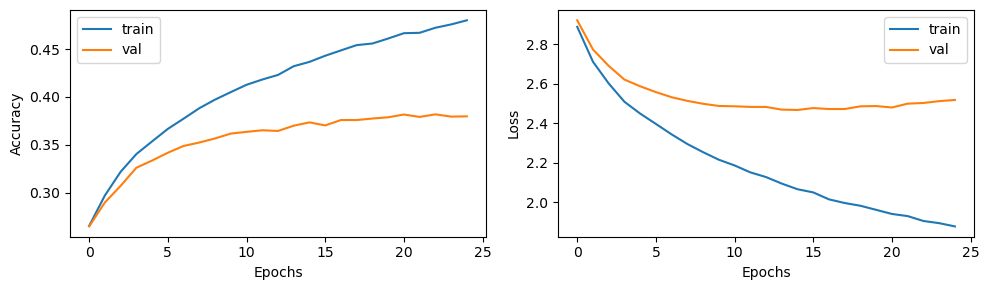

In [87]:
# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_accuracy, label='train')
axes[0].plot(validation_accuracy, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_loss, label='train')
axes[1].plot(validation_loss, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.tight_layout()
plt.show()

In [88]:
## overfitting, let's add weight_decay now! (and batch_size = 16)

## Custom Model 20

In [95]:
class CustomModel20(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, output_dim, dropout_prob=0.2):
        # let's slightly increase dropout_prob!
        super(CustomModel20, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim1)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim1, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [96]:
# Hyperparameters
hidden_size = 256 ## complex patterns at the start
hidden_size1 = 128 ## slightly less complex towards the end??
learning_rate = 0.001
epochs = 200
batch_size = 16 
patience = 10
weight_decay = 0.0001 ## will it solve overfitting?!

# Create model instance
model = CustomModel20(input_size, hidden_size, hidden_size1, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [97]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)


Training Results - Epoch[1] Avg accuracy: 0.26 Avg loss: 2.89
Validation Results - Epoch[1] Avg accuracy: 0.26 Avg loss: 2.92
Training Results - Epoch[2] Avg accuracy: 0.30 Avg loss: 2.72
Validation Results - Epoch[2] Avg accuracy: 0.29 Avg loss: 2.78
Training Results - Epoch[3] Avg accuracy: 0.31 Avg loss: 2.63
Validation Results - Epoch[3] Avg accuracy: 0.30 Avg loss: 2.71
Training Results - Epoch[4] Avg accuracy: 0.33 Avg loss: 2.55
Validation Results - Epoch[4] Avg accuracy: 0.32 Avg loss: 2.65
Training Results - Epoch[5] Avg accuracy: 0.34 Avg loss: 2.50
Validation Results - Epoch[5] Avg accuracy: 0.32 Avg loss: 2.62
Training Results - Epoch[6] Avg accuracy: 0.35 Avg loss: 2.44
Validation Results - Epoch[6] Avg accuracy: 0.33 Avg loss: 2.58
Training Results - Epoch[7] Avg accuracy: 0.37 Avg loss: 2.40
Validation Results - Epoch[7] Avg accuracy: 0.34 Avg loss: 2.56
Training Results - Epoch[8] Avg accuracy: 0.37 Avg loss: 2.36
Validation Results - Epoch[8] Avg accuracy: 0.35 Avg los

State:
	iteration: 67375
	epoch: 35
	epoch_length: 1925
	max_epochs: 200
	output: 1.8337032794952393
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Custom Model 21

In [98]:
# let's try with batch_size = 32 but dropout_prob at 0.5

In [106]:
class CustomModel21(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, output_dim, dropout_prob=0.5):
        # let's slightly increase dropout_prob!
        super(CustomModel21, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim1)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim1, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [107]:
# Hyperparameters
hidden_size = 256 ## complex patterns at the start
hidden_size1 = 128 ## slightly less complex towards the end??
learning_rate = 0.001
epochs = 200
batch_size = 32
patience = 20
weight_decay = 0.0001 ## will it solve overfitting?!

# Create model instance
model = CustomModel20(input_size, hidden_size, hidden_size1, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [108]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)


Training Results - Epoch[1] Avg accuracy: 0.27 Avg loss: 2.89
Validation Results - Epoch[1] Avg accuracy: 0.26 Avg loss: 2.92
Training Results - Epoch[2] Avg accuracy: 0.30 Avg loss: 2.72
Validation Results - Epoch[2] Avg accuracy: 0.29 Avg loss: 2.78
Training Results - Epoch[3] Avg accuracy: 0.32 Avg loss: 2.61
Validation Results - Epoch[3] Avg accuracy: 0.31 Avg loss: 2.69
Training Results - Epoch[4] Avg accuracy: 0.34 Avg loss: 2.54
Validation Results - Epoch[4] Avg accuracy: 0.32 Avg loss: 2.64
Training Results - Epoch[5] Avg accuracy: 0.35 Avg loss: 2.47
Validation Results - Epoch[5] Avg accuracy: 0.33 Avg loss: 2.59
Training Results - Epoch[6] Avg accuracy: 0.36 Avg loss: 2.42
Validation Results - Epoch[6] Avg accuracy: 0.34 Avg loss: 2.55
Training Results - Epoch[7] Avg accuracy: 0.37 Avg loss: 2.36
Validation Results - Epoch[7] Avg accuracy: 0.35 Avg loss: 2.52
Training Results - Epoch[8] Avg accuracy: 0.38 Avg loss: 2.32
Validation Results - Epoch[8] Avg accuracy: 0.35 Avg los

State:
	iteration: 84700
	epoch: 44
	epoch_length: 1925
	max_epochs: 200
	output: 1.6178339719772339
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

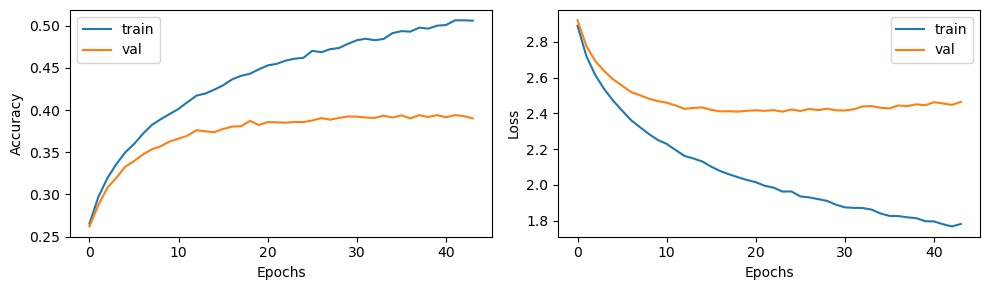

In [110]:
# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_accuracy, label='train')
axes[0].plot(validation_accuracy, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_loss, label='train')
axes[1].plot(validation_loss, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.tight_layout()
plt.show()

In [105]:
## Let's try to easen up early stopping, there's room for improvement!

In [ ]:
## Since there are slight signs of overfitting, let's introduce more dropout between hidden layers (ceteris paribus)

## Custom Model 22

In [111]:
class CustomModel22(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, output_dim, dropout_prob=0.5):
        # let's slightly increase dropout_prob!
        super(CustomModel22, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim1)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim1, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [112]:
# Hyperparameters
hidden_size = 256 ## complex patterns at the start
hidden_size1 = 128 ## slightly less complex towards the end??
learning_rate = 0.001
epochs = 200
batch_size = 32
patience = 20
weight_decay = 0.0001 ## will it solve overfitting?!

# Create model instance
model = CustomModel22(input_size, hidden_size, hidden_size1, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [113]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)


Training Results - Epoch[1] Avg accuracy: 0.23 Avg loss: 3.15
Validation Results - Epoch[1] Avg accuracy: 0.22 Avg loss: 3.16
Training Results - Epoch[2] Avg accuracy: 0.25 Avg loss: 3.01
Validation Results - Epoch[2] Avg accuracy: 0.25 Avg loss: 3.03
Training Results - Epoch[3] Avg accuracy: 0.25 Avg loss: 2.95
Validation Results - Epoch[3] Avg accuracy: 0.25 Avg loss: 2.98
Training Results - Epoch[4] Avg accuracy: 0.26 Avg loss: 2.91
Validation Results - Epoch[4] Avg accuracy: 0.26 Avg loss: 2.93
Training Results - Epoch[5] Avg accuracy: 0.27 Avg loss: 2.88
Validation Results - Epoch[5] Avg accuracy: 0.27 Avg loss: 2.91
Training Results - Epoch[6] Avg accuracy: 0.28 Avg loss: 2.85
Validation Results - Epoch[6] Avg accuracy: 0.27 Avg loss: 2.89
Training Results - Epoch[7] Avg accuracy: 0.28 Avg loss: 2.83
Validation Results - Epoch[7] Avg accuracy: 0.28 Avg loss: 2.86
Training Results - Epoch[8] Avg accuracy: 0.28 Avg loss: 2.80
Validation Results - Epoch[8] Avg accuracy: 0.28 Avg los

Engine run is terminating due to exception: 


KeyboardInterrupt: 

In [ ]:
# tanh can also be used in earlier layers if it fits the problem characteristics (e.g., normalized inputs).
## Too much regularization, hard to make progress!
## (actually, keep it like that but I'm going to remove weight_decay for now) and dropout_prob at 0.1

## Custom Model 23

In [114]:
class CustomModel23(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, output_dim, dropout_prob=0.1):
        # let's slightly increase dropout_prob!
        super(CustomModel23, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim1)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc4 = nn.Linear(hidden_dim1, output_dim)

        
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [115]:
# Hyperparameters
hidden_size = 256 ## complex patterns at the start
hidden_size1 = 128 ## slightly less complex towards the end??
learning_rate = 0.001
epochs = 200
batch_size = 32
patience = 20
# weight_decay = 0.0001 ## let's remove it for now

# Create model instance
model = CustomModel23(input_size, hidden_size, hidden_size1, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [116]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)


Training Results - Epoch[1] Avg accuracy: 0.28 Avg loss: 2.83
Validation Results - Epoch[1] Avg accuracy: 0.27 Avg loss: 2.87
Training Results - Epoch[2] Avg accuracy: 0.31 Avg loss: 2.68
Validation Results - Epoch[2] Avg accuracy: 0.30 Avg loss: 2.74
Training Results - Epoch[3] Avg accuracy: 0.33 Avg loss: 2.59
Validation Results - Epoch[3] Avg accuracy: 0.31 Avg loss: 2.67
Training Results - Epoch[4] Avg accuracy: 0.34 Avg loss: 2.51
Validation Results - Epoch[4] Avg accuracy: 0.32 Avg loss: 2.62
Training Results - Epoch[5] Avg accuracy: 0.35 Avg loss: 2.45
Validation Results - Epoch[5] Avg accuracy: 0.34 Avg loss: 2.57
Training Results - Epoch[6] Avg accuracy: 0.36 Avg loss: 2.42
Validation Results - Epoch[6] Avg accuracy: 0.34 Avg loss: 2.56
Training Results - Epoch[7] Avg accuracy: 0.37 Avg loss: 2.38
Validation Results - Epoch[7] Avg accuracy: 0.34 Avg loss: 2.53
Training Results - Epoch[8] Avg accuracy: 0.38 Avg loss: 2.34
Validation Results - Epoch[8] Avg accuracy: 0.35 Avg los

State:
	iteration: 385000
	epoch: 200
	epoch_length: 1925
	max_epochs: 200
	output: 1.7221577167510986
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

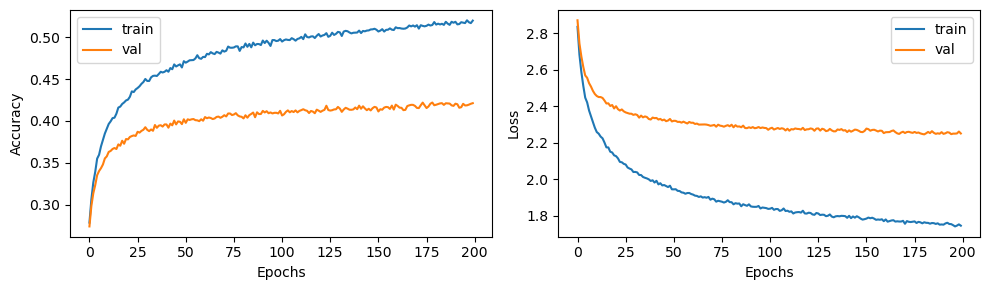

In [117]:
# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_accuracy, label='train')
axes[0].plot(validation_accuracy, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_loss, label='train')
axes[1].plot(validation_loss, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.tight_layout()
plt.show()

In [ ]:
## I want the same model as before, but with all relu this time!

## Relu Custom Model 23 - best 'til now!

In [118]:
class ReluCustomModel23(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, output_dim, dropout_prob=0.3):
        # I'm also increasing dropout_prob to 0.3 because it could be beneficial!
        super(ReluCustomModel23, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim1)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc4 = nn.Linear(hidden_dim1, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [119]:
# Hyperparameters
hidden_size = 256 ## complex patterns at the start
hidden_size1 = 128 ## slightly less complex towards the end??
learning_rate = 0.001
epochs = 200
batch_size = 32
patience = 20
# weight_decay = 0.0001 ## let's remove it for now

# Create model instance
model = ReluCustomModel23(input_size, hidden_size, hidden_size1, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [120]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)


Training Results - Epoch[1] Avg accuracy: 0.25 Avg loss: 3.00
Validation Results - Epoch[1] Avg accuracy: 0.25 Avg loss: 3.02
Training Results - Epoch[2] Avg accuracy: 0.27 Avg loss: 2.86
Validation Results - Epoch[2] Avg accuracy: 0.27 Avg loss: 2.89
Training Results - Epoch[3] Avg accuracy: 0.29 Avg loss: 2.77
Validation Results - Epoch[3] Avg accuracy: 0.28 Avg loss: 2.82
Training Results - Epoch[4] Avg accuracy: 0.30 Avg loss: 2.71
Validation Results - Epoch[4] Avg accuracy: 0.29 Avg loss: 2.76
Training Results - Epoch[5] Avg accuracy: 0.31 Avg loss: 2.67
Validation Results - Epoch[5] Avg accuracy: 0.30 Avg loss: 2.72
Training Results - Epoch[6] Avg accuracy: 0.32 Avg loss: 2.62
Validation Results - Epoch[6] Avg accuracy: 0.30 Avg loss: 2.69
Training Results - Epoch[7] Avg accuracy: 0.32 Avg loss: 2.60
Validation Results - Epoch[7] Avg accuracy: 0.31 Avg loss: 2.67
Training Results - Epoch[8] Avg accuracy: 0.33 Avg loss: 2.57
Validation Results - Epoch[8] Avg accuracy: 0.32 Avg los

Engine run is terminating due to exception: 
Engine run is terminating due to exception: 


KeyboardInterrupt: 

## Custom Model 24

In [ ]:
### we reached a plateau in validation accuracy, and we want to break it by making the model more complex!

In [126]:
class CustomModel24(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, hidden_dim2, output_dim, dropout_prob=0.3):
        # I'm also increasing dropout_prob to 0.3 because it could be beneficial!
        super(CustomModel24, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim1)
        self.fc4 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc5 = nn.Linear(hidden_dim2, output_dim)

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

In [127]:
# Hyperparameters
hidden_size = 512 ## complex patterns at the start
hidden_size1 = 256 ## slightly less complex in the middle??
hidden_size2 = 128 ## a bit simpler towards the end
learning_rate = 0.001
epochs = 200
batch_size = 32
patience = 20
weight_decay = 0.0001 ## we need more regularization so let's keep it!

# Create model instance
model = CustomModel24(input_size, hidden_size, hidden_size1, hidden_size2, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [128]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)


Training Results - Epoch[1] Avg accuracy: 0.24 Avg loss: 3.02
Validation Results - Epoch[1] Avg accuracy: 0.24 Avg loss: 3.04
Training Results - Epoch[2] Avg accuracy: 0.27 Avg loss: 2.86
Validation Results - Epoch[2] Avg accuracy: 0.27 Avg loss: 2.90
Training Results - Epoch[3] Avg accuracy: 0.29 Avg loss: 2.77
Validation Results - Epoch[3] Avg accuracy: 0.28 Avg loss: 2.82
Training Results - Epoch[4] Avg accuracy: 0.29 Avg loss: 2.73
Validation Results - Epoch[4] Avg accuracy: 0.29 Avg loss: 2.80
Training Results - Epoch[5] Avg accuracy: 0.30 Avg loss: 2.68
Validation Results - Epoch[5] Avg accuracy: 0.29 Avg loss: 2.75
Training Results - Epoch[6] Avg accuracy: 0.32 Avg loss: 2.64
Validation Results - Epoch[6] Avg accuracy: 0.30 Avg loss: 2.72
Training Results - Epoch[7] Avg accuracy: 0.32 Avg loss: 2.59
Validation Results - Epoch[7] Avg accuracy: 0.31 Avg loss: 2.68
Training Results - Epoch[8] Avg accuracy: 0.33 Avg loss: 2.57
Validation Results - Epoch[8] Avg accuracy: 0.31 Avg los

State:
	iteration: 385000
	epoch: 200
	epoch_length: 1925
	max_epochs: 200
	output: 2.273662805557251
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

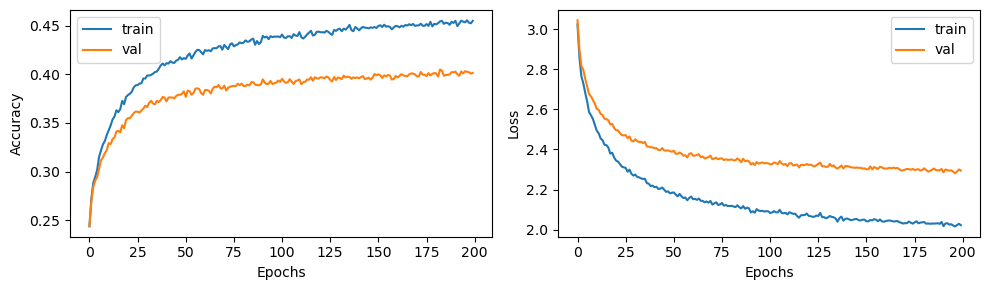

In [129]:
# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_accuracy, label='train')
axes[0].plot(validation_accuracy, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_loss, label='train')
axes[1].plot(validation_loss, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.tight_layout()
plt.show()

## Custom Model 25

In [ ]:
## Let's try and increase hidden_sizes across the board, hoping it could help detecting more complex patterns!
## At the same time, let's change relu with leakyrelu!
## Finally, to help make the model learn better, we're removing a few dropout in the forward

In [130]:
class CustomModel25(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim, dropout_prob=0.3):
        # I'm also increasing dropout_prob to 0.3 because it could be beneficial!
        super(CustomModel25, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.dropout = nn.Dropout(dropout_prob)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.fc5 = nn.Linear(hidden_dim3, output_dim)

        
    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        # x = self.dropout(x) ## Let's remove the first two dropout in order to make our model learn better hopefully!
        x = self.leaky_relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

In [131]:
# Hyperparameters
hidden_size = 1024 ## complex patterns at the start
hidden_size1 = 512 
hidden_size2 = 256 ## slightly less complex in the middle
hidden_size3 = 128  ## a bit simpler towards the end
learning_rate = 0.001
epochs = 200
batch_size = 32
patience = 10
weight_decay = 0.0001 ## we need more regularization so let's keep it!

# Create model instance
model = CustomModel25(input_size, hidden_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [132]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)


Training Results - Epoch[1] Avg accuracy: 0.26 Avg loss: 2.93
Validation Results - Epoch[1] Avg accuracy: 0.25 Avg loss: 2.96
Training Results - Epoch[2] Avg accuracy: 0.29 Avg loss: 2.76
Validation Results - Epoch[2] Avg accuracy: 0.28 Avg loss: 2.83
Training Results - Epoch[3] Avg accuracy: 0.31 Avg loss: 2.66
Validation Results - Epoch[3] Avg accuracy: 0.30 Avg loss: 2.74
Training Results - Epoch[4] Avg accuracy: 0.32 Avg loss: 2.60
Validation Results - Epoch[4] Avg accuracy: 0.31 Avg loss: 2.70
Training Results - Epoch[5] Avg accuracy: 0.34 Avg loss: 2.54
Validation Results - Epoch[5] Avg accuracy: 0.32 Avg loss: 2.66
Training Results - Epoch[6] Avg accuracy: 0.35 Avg loss: 2.47
Validation Results - Epoch[6] Avg accuracy: 0.33 Avg loss: 2.60
Training Results - Epoch[7] Avg accuracy: 0.36 Avg loss: 2.43
Validation Results - Epoch[7] Avg accuracy: 0.34 Avg loss: 2.58
Training Results - Epoch[8] Avg accuracy: 0.37 Avg loss: 2.39
Validation Results - Epoch[8] Avg accuracy: 0.34 Avg los

State:
	iteration: 144375
	epoch: 75
	epoch_length: 1925
	max_epochs: 200
	output: 1.8968901634216309
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Custom Model 26

In [133]:
class CustomModel26(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim, dropout_prob=0.3):
        # I'm also increasing dropout_prob to 0.3 because it could be beneficial!
        super(CustomModel26, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, hidden_dim4)
        self.dropout = nn.Dropout(dropout_prob)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.fc6 = nn.Linear(hidden_dim4, output_dim)

        
    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        # x = self.dropout(x) ## Let's remove the first two dropout in order to make our model learn better hopefully!
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc4(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x

In [134]:
# Hyperparameters
hidden_size = 1024 ## complex patterns at the start
hidden_size1 = 512 
hidden_size2 = 256 ## slightly less complex in the middle
hidden_size3 = 128 
hidden_size4 = 64 
#h_s4 could potentially help in capturing more detailed patterns that were not fully captured by larger layers
learning_rate = 0.0005 # let's go with 0.0005, why not, their performance was similar
epochs = 200
batch_size = 32
patience = 10
weight_decay = 0.0001 #keep it

# Create model instance
model = CustomModel26(input_size, hidden_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [135]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)


Training Results - Epoch[1] Avg accuracy: 0.22 Avg loss: 3.18
Validation Results - Epoch[1] Avg accuracy: 0.22 Avg loss: 3.20
Training Results - Epoch[2] Avg accuracy: 0.24 Avg loss: 3.02
Validation Results - Epoch[2] Avg accuracy: 0.24 Avg loss: 3.05
Training Results - Epoch[3] Avg accuracy: 0.26 Avg loss: 2.93
Validation Results - Epoch[3] Avg accuracy: 0.26 Avg loss: 2.97
Training Results - Epoch[4] Avg accuracy: 0.27 Avg loss: 2.88
Validation Results - Epoch[4] Avg accuracy: 0.27 Avg loss: 2.92
Training Results - Epoch[5] Avg accuracy: 0.28 Avg loss: 2.81
Validation Results - Epoch[5] Avg accuracy: 0.28 Avg loss: 2.87
Training Results - Epoch[6] Avg accuracy: 0.29 Avg loss: 2.77
Validation Results - Epoch[6] Avg accuracy: 0.28 Avg loss: 2.84
Training Results - Epoch[7] Avg accuracy: 0.30 Avg loss: 2.74
Validation Results - Epoch[7] Avg accuracy: 0.29 Avg loss: 2.81
Training Results - Epoch[8] Avg accuracy: 0.30 Avg loss: 2.72
Validation Results - Epoch[8] Avg accuracy: 0.29 Avg los

Engine run is terminating due to exception: 


KeyboardInterrupt: 

## Custom Model 27

In [136]:
class CustomModel27(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim, dropout_prob=0.3):
        # I'm also increasing dropout_prob to 0.3 because it could be beneficial!
        super(CustomModel27, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.dropout = nn.Dropout(dropout_prob)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.fc5 = nn.Linear(hidden_dim3, output_dim)

        
    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        # x = self.dropout(x) ## Let's remove the first dropout in order to make our model learn better hopefully!
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

In [137]:
# Hyperparameters
hidden_size = 1024 ## complex patterns at the start
hidden_size1 = 512 
hidden_size2 = 256 ## slightly less complex in the middle
hidden_size3 = 128 
learning_rate = 0.001 # back to 0.001, faster convergence
epochs = 200
batch_size = 64 # let's try batch_size = 64!
patience = 10
weight_decay = 0.0001 ## we need more regularization so let's keep it!

# Create model instance
model = CustomModel27(input_size, hidden_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [138]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)


Training Results - Epoch[1] Avg accuracy: 0.25 Avg loss: 2.97
Validation Results - Epoch[1] Avg accuracy: 0.24 Avg loss: 3.00
Training Results - Epoch[2] Avg accuracy: 0.27 Avg loss: 2.83
Validation Results - Epoch[2] Avg accuracy: 0.27 Avg loss: 2.88
Training Results - Epoch[3] Avg accuracy: 0.29 Avg loss: 2.74
Validation Results - Epoch[3] Avg accuracy: 0.28 Avg loss: 2.80
Training Results - Epoch[4] Avg accuracy: 0.31 Avg loss: 2.67
Validation Results - Epoch[4] Avg accuracy: 0.30 Avg loss: 2.75
Training Results - Epoch[5] Avg accuracy: 0.32 Avg loss: 2.63
Validation Results - Epoch[5] Avg accuracy: 0.30 Avg loss: 2.72
Training Results - Epoch[6] Avg accuracy: 0.33 Avg loss: 2.56
Validation Results - Epoch[6] Avg accuracy: 0.32 Avg loss: 2.66
Training Results - Epoch[7] Avg accuracy: 0.34 Avg loss: 2.51
Validation Results - Epoch[7] Avg accuracy: 0.32 Avg loss: 2.62
Training Results - Epoch[8] Avg accuracy: 0.35 Avg loss: 2.48
Validation Results - Epoch[8] Avg accuracy: 0.33 Avg los

State:
	iteration: 159775
	epoch: 83
	epoch_length: 1925
	max_epochs: 200
	output: 1.9694056510925293
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

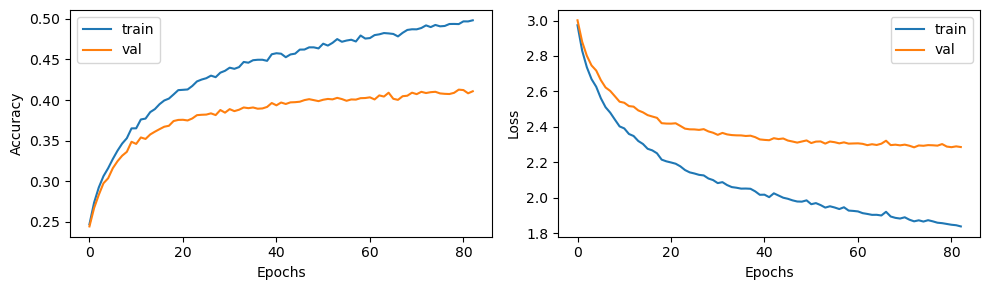

In [139]:
# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_accuracy, label='train')
axes[0].plot(validation_accuracy, label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_loss, label='train')
axes[1].plot(validation_loss, label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.tight_layout()
plt.show()

## Custom Model 28

In [141]:
class CustomModel28(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim, dropout_prob=0.5):
        # I'm also increasing dropout_prob to 0.5 because it could be beneficial!
        super(CustomModel28, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc5 = nn.Linear(hidden_dim3, hidden_dim4)
        self.dropout = nn.Dropout(dropout_prob)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.fc6 = nn.Linear(hidden_dim4, output_dim)

        
    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        # x = self.dropout(x) ## Let's remove the first dropout in order to make our model learn better hopefully!
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc4(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x

In [142]:
# Hyperparameters
hidden_size = 1024 ## complex patterns at the start
hidden_size1 = 512 
hidden_size2 = 256 ## slightly less complex in the middle
hidden_size3 = 128 
hidden_size4 = 64
learning_rate = 0.001
epochs = 200
batch_size = 64 # let's try to keep batch_size = 64!
patience = 10
weight_decay = 0.0001 ## we need more regularization so let's keep it!

# Create model instance
model = CustomModel28(input_size, hidden_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [143]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)


Training Results - Epoch[1] Avg accuracy: 0.17 Avg loss: 3.42
Validation Results - Epoch[1] Avg accuracy: 0.17 Avg loss: 3.43
Training Results - Epoch[2] Avg accuracy: 0.20 Avg loss: 3.23
Validation Results - Epoch[2] Avg accuracy: 0.20 Avg loss: 3.25
Training Results - Epoch[3] Avg accuracy: 0.22 Avg loss: 3.13
Validation Results - Epoch[3] Avg accuracy: 0.22 Avg loss: 3.16
Training Results - Epoch[4] Avg accuracy: 0.23 Avg loss: 3.08
Validation Results - Epoch[4] Avg accuracy: 0.23 Avg loss: 3.11
Training Results - Epoch[5] Avg accuracy: 0.24 Avg loss: 3.04
Validation Results - Epoch[5] Avg accuracy: 0.23 Avg loss: 3.07
Training Results - Epoch[6] Avg accuracy: 0.24 Avg loss: 3.01
Validation Results - Epoch[6] Avg accuracy: 0.24 Avg loss: 3.05
Training Results - Epoch[7] Avg accuracy: 0.25 Avg loss: 2.98
Validation Results - Epoch[7] Avg accuracy: 0.24 Avg loss: 3.03
Training Results - Epoch[8] Avg accuracy: 0.25 Avg loss: 2.97
Validation Results - Epoch[8] Avg accuracy: 0.25 Avg los

State:
	iteration: 163625
	epoch: 85
	epoch_length: 1925
	max_epochs: 200
	output: 2.79713773727417
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

# Final Model

In [33]:
class CustomModel25(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim, dropout_prob=0.2):
        # I'm also increasing dropout_prob to 0.3 because it could be beneficial!
        super(CustomModel25, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.dropout = nn.Dropout(dropout_prob)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.fc5 = nn.Linear(hidden_dim3, output_dim)

        
    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x) 
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

In [36]:
# Hyperparameters
hidden_size = 1024 ## complex patterns at the start
hidden_size1 = 512 
hidden_size2 = 256 ## slightly less complex in the middle
hidden_size3 = 128  ## a bit simpler towards the end
learning_rate = 0.001
epochs = 200
batch_size = 32
patience = 10
weight_decay = 0.0001 ## we need more regularization so let's keep it!
input_size = X_train.shape[1]
output_size = 113


# Create model instance
model = CustomModel25(input_size, hidden_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer with weight decay (for L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Ignite engine setup
trainer = Engine(lambda engine, batch: train_step(engine, batch, model, optimizer, criterion, device))
evaluator = Engine(lambda engine, batch: val_step(engine, batch, model, criterion, device))

# Attach metrics to the evaluator
metrics = {
    'accuracy': Accuracy(),
    'loss': Loss(criterion)
}
for name, metric in metrics.items():
    metric.attach(evaluator, name)


In [68]:
# Training step function
def train_step(engine, batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation step function
def val_step(engine, batch, model, criterion, device):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

# Early stopping variables
best_val_loss = float('inf')
current_patience = 0

# Lists to store metrics
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Event handlers
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    train_acc = metrics['accuracy']
    train_loss = metrics['loss']
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {train_acc:.2f} Avg loss: {train_loss:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_val_loss, current_patience
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    val_acc = metrics['accuracy']
    val_loss = metrics['loss']
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {val_acc:.2f} Avg loss: {val_loss:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping triggered.")
            trainer.terminate()

# Training loop
trainer.run(train_loader, max_epochs=epochs)

# Evaluate on test set after training is complete
evaluator.run(test_loader)
test_metrics = evaluator.state.metrics
test_acc = test_metrics['accuracy']
test_loss = test_metrics['loss']
print(f"Test Results - Avg accuracy: {test_acc:.2f} Avg loss: {test_loss:.2f}")

# Compute predictions and targets for classification report
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        all_preds.append(y_pred.argmax(dim=1).cpu().numpy())
        all_targets.append(y.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Generate classification report
print("Classification Report:")
print(classification_report(all_targets, all_preds, digits=4))


Training Results - Epoch[1] Avg accuracy: 0.26 Avg loss: 2.93
Validation Results - Epoch[1] Avg accuracy: 0.25 Avg loss: 2.96
Training Results - Epoch[2] Avg accuracy: 0.28 Avg loss: 2.77
Validation Results - Epoch[2] Avg accuracy: 0.28 Avg loss: 2.83
Training Results - Epoch[3] Avg accuracy: 0.30 Avg loss: 2.69
Validation Results - Epoch[3] Avg accuracy: 0.29 Avg loss: 2.76
Training Results - Epoch[4] Avg accuracy: 0.32 Avg loss: 2.60
Validation Results - Epoch[4] Avg accuracy: 0.31 Avg loss: 2.69
Training Results - Epoch[5] Avg accuracy: 0.33 Avg loss: 2.55
Validation Results - Epoch[5] Avg accuracy: 0.31 Avg loss: 2.66
Training Results - Epoch[6] Avg accuracy: 0.34 Avg loss: 2.51
Validation Results - Epoch[6] Avg accuracy: 0.32 Avg loss: 2.63
Training Results - Epoch[7] Avg accuracy: 0.35 Avg loss: 2.46
Validation Results - Epoch[7] Avg accuracy: 0.33 Avg loss: 2.60
Training Results - Epoch[8] Avg accuracy: 0.36 Avg loss: 2.43
Validation Results - Epoch[8] Avg accuracy: 0.34 Avg los

C:\Users\rugge\anaconda3\envs\neuralnetworks\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rugge\anaconda3\envs\neuralnetworks\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rugge\anaconda3\envs\neuralnetworks\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [72]:
# Assuming y_test_encoded contains encoded labels and y_test contains real labels
unique_encoded_labels = np.unique(y_test_encoded)
unique_real_labels = np.unique(y_new_test)

# Create label map from encoded to real labels
label_map = {encoded: real for encoded, real in zip(unique_encoded_labels, unique_real_labels)}

# Convert encoded labels to real labels using the label_map
all_preds_real = np.array([label_map[p] for p in all_preds])
all_targets_real = np.array([label_map[t] for t in all_targets])

# Generate classification report with real labels
print("Classification Report:")
print(classification_report(all_targets_real, all_preds_real, digits=4))

Classification Report:
                   precision    recall  f1-score   support

         acoustic     0.2667    0.2963    0.2807        54
         afrobeat     0.2769    0.3051    0.2903        59
         alt-rock     0.0000    0.0000    0.0000        15
      alternative     0.3235    0.4583    0.3793        48
          ambient     0.4872    0.3393    0.4000        56
            anime     0.3158    0.2791    0.2963        43
      black-metal     0.5139    0.6379    0.5692        58
        bluegrass     0.3699    0.4576    0.4091        59
            blues     0.3214    0.1957    0.2432        46
           brazil     0.2083    0.0862    0.1220        58
        breakbeat     0.4386    0.4310    0.4348        58
          british     0.6000    0.2647    0.3673        34
         cantopop     0.4762    0.3774    0.4211        53
    chicago-house     0.4407    0.4407    0.4407        59
         children     0.5217    0.4068    0.4571        59
            chill     0.3226    

C:\Users\rugge\anaconda3\envs\neuralnetworks\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rugge\anaconda3\envs\neuralnetworks\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rugge\anaconda3\envs\neuralnetworks\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

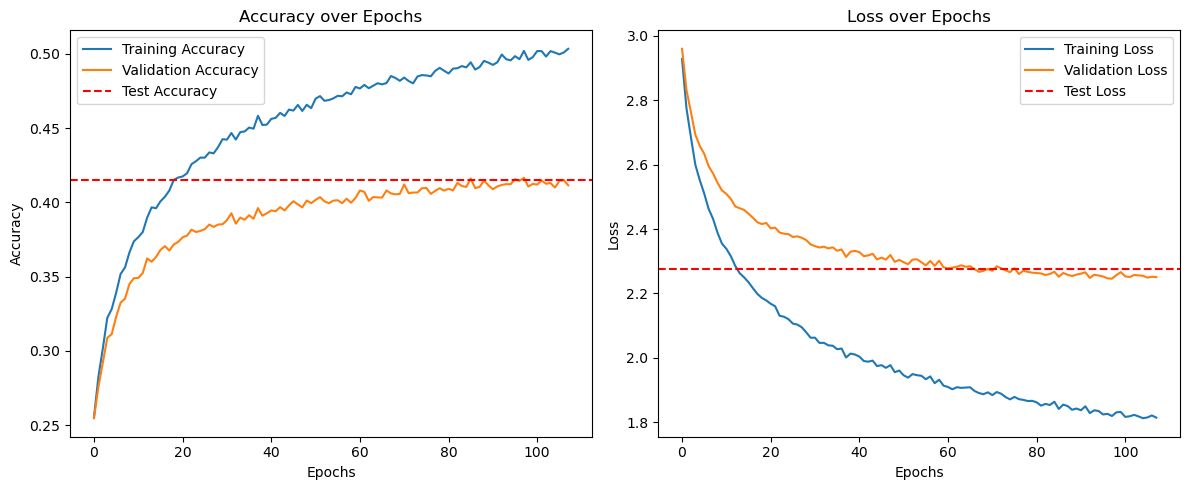

In [92]:
import matplotlib.pyplot as plt

# Assuming test_acc and test_loss are defined from your evaluation on the test set

# Plotting results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Accuracy plot
axes[0].plot(training_accuracy, label='Training Accuracy')
axes[0].plot(validation_accuracy, label='Validation Accuracy')
axes[0].axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy over Epochs')
axes[0].legend()

# Loss plot
axes[1].plot(training_loss, label='Training Loss')
axes[1].plot(validation_loss, label='Validation Loss')
axes[1].axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss over Epochs')
axes[1].legend()

fig.tight_layout()
plt.show()
